## Model Building and Training

### Data Preparation

In [31]:
import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn  # For sklearn models
import mlflow.keras    # For Keras models
import warning

warning.


In [32]:
fraud_df = pd.read_csv("../Notebooks/fraud_dataset.csv")
creditcard_df = pd.read_csv("../data/creditcard.csv")

In [33]:
fraud_df.head(5)

,user_id,signup_time,purchase_time,purchase_value,device_id,age,ip_address,class,country,transaction_count,transaction_velocity,hour_of_day,day_of_week,browser_FireFox,browser_IE,browser_Opera,browser_Safari,source_Direct,source_SEO,sex_M
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,-0.160204,QVPSPJUOCKZAR,39,7.327584e+08,0,Japan,0.0,0.0,2,5,False,False,False,False,False,True,True
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,-1.142592,EOGFQPIZPYXFZ,53,3.503114e+08,0,United States,0.0,0.0,1,0,False,False,False,False,False,False,False
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,-1.197169,YSSKYOSJHPPLJ,53,2.621474e+09,1,Unknown,0.0,0.0,18,3,False,False,True,False,False,True,True
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,0.385567,ATGTXKYKUDUQN,41,3.840542e+09,0,Unknown,0.0,0.0,13,0,False,False,False,True,False,True,True
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,0.112681,NAUITBZFJKHWW,45,4.155831e+08,0,United States,0.0,0.0,18,2,False,False,False,True,False,False,True


In [34]:
creditcard_df.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [35]:
fraud_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 20 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   user_id               151112 non-null  int64  
 1   signup_time           151112 non-null  object 
 2   purchase_time         151112 non-null  object 
 3   purchase_value        151112 non-null  float64
 4   device_id             151112 non-null  object 
 5   age                   151112 non-null  int64  
 6   ip_address            151112 non-null  float64
 7   class                 151112 non-null  int64  
 8   country               151112 non-null  object 
 9   transaction_count     151112 non-null  float64
 10  transaction_velocity  151112 non-null  float64
 11  hour_of_day           151112 non-null  int64  
 12  day_of_week           151112 non-null  int64  
 13  browser_FireFox       151112 non-null  bool   
 14  browser_IE            151112 non-null  bool   
 15  

#### Feature and Target Separation

In [36]:
# Correcting data types
fraud_df['signup_time'] = pd.to_datetime(fraud_df['signup_time'])
fraud_df['purchase_time'] = pd.to_datetime(fraud_df['purchase_time'])
fraud_df['ip_address'] = fraud_df['ip_address'].fillna(0).astype(int)

In [37]:
# Create a new feature: time difference between signup and purchase (in minutes)
fraud_df['time_diff_minutes'] = (fraud_df['purchase_time'] - fraud_df['signup_time']).dt.total_seconds() / 60.0

# Extract additional features from 'purchase_time'
fraud_df['purchase_hour'] = fraud_df['purchase_time'].dt.hour
fraud_df['purchase_day'] = fraud_df['purchase_time'].dt.day
fraud_df['purchase_month'] = fraud_df['purchase_time'].dt.month

In [38]:
# Drop the original 'signup_time' and 'purchase_time' columns
fraud_df = fraud_df.drop(columns=['signup_time','purchase_time'])

In [39]:
from sklearn.preprocessing import LabelEncoder

#  Label encoding for categorical columns in Fraud_Data
label_encoder = LabelEncoder()
fraud_df['device_id'] = label_encoder.fit_transform(fraud_df['device_id'])

In [48]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Replace 'Unknown' with NaN
fraud_df = fraud_df.replace('Unknown', np.nan)

categorical_cols = ['country']

# Preprocessing for categorical data
categorical_transformer = SimpleImputer(strategy='most_frequent') 

# Preprocessing for categorical data (e.g., filling missing values with most frequent value and one-hot encoding)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Fill missing values in categorical columns
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode the categorical column
])

# Combine preprocessing steps for numerical and categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_cols)
    ])

### Preprocessing

In [41]:
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Replace 'Unknown' with NaN
fraud_df = fraud_df.replace('Unknown', np.nan)

# Define categorical and numerical columns
categorical_cols = ['country']  # Add other categorical columns if needed
numerical_cols = fraud_df.select_dtypes(include=['int64', 'float64', 'bool']).columns.tolist()

# Preprocessing for numerical data (e.g., filling missing values with mean)
numerical_transformer = SimpleImputer(strategy='mean')

# Preprocessing for categorical data (e.g., filling missing values with most frequent value and one-hot encoding)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Fill missing values in categorical columns
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode the categorical column
])

# Combine preprocessing steps for numerical and categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [42]:
# For Fraud_Data.csv
y_fraud = fraud_df['class']
X_fraud = fraud_df.drop(columns=['class'])


# For creditcard.csv
y_creditcard = creditcard_df['Class']
X_creditcard = creditcard_df.drop(columns=['Class'])


#### Train-Test Split:

In [43]:
import mlflow
import mlflow.sklearn  # For sklearn models
from sklearn.model_selection import train_test_split

# Set up an experiment
mlflow.set_experiment("Frauds Detection Experiment")

# Split Fraud Data
X_fraud_train, X_fraud_test, y_fraud_train, y_fraud_test = train_test_split(X_fraud, y_fraud, test_size=0.2, random_state=42)

# Split Credit Card Data
X_creditcard_train, X_creditcard_test, y_creditcard_train, y_creditcard_test = train_test_split(X_creditcard, y_creditcard, test_size=0.2, random_state=42)

In [44]:
X_fraud_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 120889 entries, 119187 to 121958
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   user_id               120889 non-null  int64  
 1   purchase_value        120889 non-null  float64
 2   device_id             120889 non-null  int32  
 3   age                   120889 non-null  int64  
 4   ip_address            120889 non-null  int32  
 5   country               58496 non-null   object 
 6   transaction_count     120889 non-null  float64
 7   transaction_velocity  120889 non-null  float64
 8   hour_of_day           120889 non-null  int64  
 9   day_of_week           120889 non-null  int64  
 10  browser_FireFox       120889 non-null  bool   
 11  browser_IE            120889 non-null  bool   
 12  browser_Opera         120889 non-null  bool   
 13  browser_Safari        120889 non-null  bool   
 14  source_Direct         120889 non-null  bool   
 15  

### Model Selection

#### Traditional Models:

#### Extract useful features from the datetime columns

In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score


# Initialize models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier()
}


    
   

# Train and log results for sklearn models (Fraud Data)
for name, model in models.items():
    with mlflow.start_run(run_name=name):
        # Create a pipeline with preprocessing and model
        clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', model)])
        clf.fit(X_fraud_train, y_fraud_train)
        y_pred_fraud = clf.predict(X_fraud_test)
        
        # Log parameters and metrics
        mlflow.log_params(model.get_params())
        accuracy = accuracy_score(y_fraud_test, y_pred_fraud)
        mlflow.log_metric("accuracy", accuracy)
        mlflow.sklearn.log_model(model, name)

        # Output classification report
        print(f"{name} - Fraud Data:")
        print(classification_report(y_fraud_test, y_pred_fraud))
        print("Accuracy:", accuracy)
        
        mlflow.end_run()  # End the current run

2024/10/23 11:42:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logistic Regression - Fraud Data:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     27373
           1       0.00      0.00      0.00      2850

    accuracy                           0.91     30223
   macro avg       0.45      0.50      0.48     30223
weighted avg       0.82      0.91      0.86     30223

Accuracy: 0.9057009562253913


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use 

Decision Tree - Fraud Data:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     27373
           1       0.44      0.00      0.00      2850

    accuracy                           0.91     30223
   macro avg       0.68      0.50      0.48     30223
weighted avg       0.86      0.91      0.86     30223

Accuracy: 0.9056678688416107


2024/10/23 11:42:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Random Forest - Fraud Data:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     27373
           1       0.44      0.00      0.00      2850

    accuracy                           0.91     30223
   macro avg       0.68      0.50      0.48     30223
weighted avg       0.86      0.91      0.86     30223

Accuracy: 0.9056678688416107


2024/10/23 11:43:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Gradient Boosting - Fraud Data:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     27373
           1       0.00      0.00      0.00      2850

    accuracy                           0.91     30223
   macro avg       0.45      0.50      0.48     30223
weighted avg       0.82      0.91      0.86     30223

Accuracy: 0.9057009562253913


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use 

In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, LSTM, Embedding, Dropout
from sklearn.preprocessing import StandardScaler

# # Scale data for Neural Networks
# scaler = StandardScaler()
# X_creditcard_scaled = scaler.fit_transform(X_creditcard)
# Scaling data for neural networks
scaler = StandardScaler()
X_creditcard_train_scaled = scaler.fit_transform(X_creditcard_train)
X_creditcard_test_scaled = scaler.transform(X_creditcard_test)

# # Reshape for CNN (assuming 2D structure, modify according to your features)
# X_creditcard_cnn = X_creditcard_scaled.reshape(-1, X_creditcard_scaled.shape[1], 1)

# MLP Model
def create_mlp_model(input_shape):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(input_shape,)))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

mlp_model = create_mlp_model(X_creditcard.shape[1])
mlp_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Start a new MLflow run for MLP
with mlflow.start_run(run_name="MLP"):
    mlflow.log_param("model_type", "MLP")
    mlflow.log_param("epochs", 10)
    mlp_model.fit(X_creditcard_train_scaled, y_creditcard_train, epochs=10, batch_size=32, validation_data=(X_creditcard_test_scaled, y_creditcard_test))

    # Log model and accuracy
    accuracy = mlp_model.evaluate(X_creditcard_test_scaled, y_creditcard_test)[1]
    mlflow.log_metric("accuracy", accuracy)
    mlflow.keras.log_model(mlp_model, "mlp_model")
    mlflow.end_run()  # End the current run
# mlp_model.fit(X_creditcard_train, y_creditcard_train, epochs=10, batch_size=32, validation_data=(X_creditcard_test, y_creditcard_test))


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
7121/7121 ━━━━━━━━━━━━━━━━━━━━ 31s 4ms/step - accuracy: 0.9929 - loss: 0.0277 - val_accuracy: 0.9992 - val_loss: 0.0042
Epoch 2/10
7121/7121 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - accuracy: 0.9993 - loss: 0.0042 - val_accuracy: 0.9993 - val_loss: 0.0034
Epoch 3/10
7121/7121 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.9994 - loss: 0.0035 - val_accuracy: 0.9994 - val_loss: 0.0029
Epoch 4/10
7121/7121 ━━━━━━━━━━━━━━━━━━━━ 39s 3ms/step - accuracy: 0.9992 - loss: 0.0039 - val_accuracy: 0.9994 - val_loss: 0.0038
Epoch 5/10
7121/7121 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - accuracy: 0.9994 - loss: 0.0032 - val_accuracy: 0.9994 - val_loss: 0.0030
Epoch 6/10
7121/7121 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.9993 - loss: 0.0032 - val_accuracy: 0.9994 - val_loss: 0.0028
Epoch 7/10
7121/7121 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - accuracy: 0.9994 - loss: 0.0030 - val_accuracy: 0.9993 - val_loss: 0.0030
Epoch 8/10
7121/7121 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9995 - loss: 0

2024/10/23 11:47:46 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/10/23 11:48:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [51]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense

# Scale data for Neural Networks
scaler = StandardScaler()
X_creditcard_scaled = scaler.fit_transform(X_creditcard)
X_creditcard_train = scaler.fit_transform(X_creditcard_train)
X_creditcard_test = scaler.fit_transform(X_creditcard_test)

# X_creditcard_cnn = X_creditcard_train.reshape(-1, X_creditcard_scaled.shape[1], 1)
# X_creditcard_cnn_test = X_creditcard_test.reshape(-1, X_creditcard_scaled.shape[1], 1)
# Reshape data for CNN
X_creditcard_train_cnn = X_creditcard_train_scaled.reshape(-1, X_creditcard_train_scaled.shape[1], 1)
X_creditcard_test_cnn = X_creditcard_test_scaled.reshape(-1, X_creditcard_test_scaled.shape[1], 1)


# Adjust the CNN model for 1D data
cnn_model = Sequential()

# Assuming X_creditcard_cnn has shape (samples, 30 features, 1 channel)
cnn_model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(30, 1)))
cnn_model.add(Flatten())
cnn_model.add(Dense(1, activation='sigmoid'))

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Start a new MLflow run for CNN
with mlflow.start_run(run_name="CNN"):
    cnn_model.fit(X_creditcard_train_cnn, y_creditcard_train, epochs=10, batch_size=32)
    
    # Log model and accuracy
    accuracy = cnn_model.evaluate(X_creditcard_test_cnn, y_creditcard_test)[1]
    mlflow.log_metric("accuracy", accuracy)
    mlflow.keras.log_model(cnn_model, "cnn_model")
    mlflow.end_run()
# Train the model
# cnn_model.fit(X_creditcard_cnn, y_creditcard_train, epochs=10, batch_size=32)


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
7121/7121 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - accuracy: 0.9961 - loss: 0.0221
Epoch 2/10
7121/7121 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - accuracy: 0.9993 - loss: 0.0033
Epoch 3/10
7121/7121 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - accuracy: 0.9994 - loss: 0.0032
Epoch 4/10
7121/7121 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9994 - loss: 0.0032
Epoch 5/10
7121/7121 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9995 - loss: 0.0026
Epoch 6/10
7121/7121 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9995 - loss: 0.0027
Epoch 7/10
7121/7121 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.9993 - loss: 0.0031
Epoch 8/10
7121/7121 ━━━━━━━━━━━━━━━━━━━━ 46s 4ms/step - accuracy: 0.9995 - loss: 0.0024
Epoch 9/10
7121/7121 ━━━━━━━━━━━━━━━━━━━━ 45s 4ms/step - accuracy: 0.9994 - loss: 0.0028
Epoch 10/10
7121/7121 ━━━━━━━━━━━━━━━━━━━━ 31s 4ms/step - accuracy: 0.9994 - loss: 0.0031
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9994 - loss: 0.0028


2024/10/23 11:53:25 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/10/23 11:54:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [52]:
# LSTM Model (assuming sequential data)
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(X_creditcard.shape[1], 1)))
lstm_model.add(Dense(1, activation='sigmoid'))
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Start a new MLflow run for LSTM
with mlflow.start_run(run_name="LSTM"):
    lstm_model.fit(X_creditcard_train_cnn, y_creditcard_train, epochs=10, batch_size=32)
    
    # Log model and accuracy
    accuracy = lstm_model.evaluate(X_creditcard_test_cnn, y_creditcard_test)[1]
    mlflow.log_metric("accuracy", accuracy)
    mlflow.keras.log_model(lstm_model, "lstm_model")
    mlflow.end_run()
# lstm_model.fit(X_creditcard_train, y_creditcard_train, epochs=10, batch_size=32)

c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
7121/7121 ━━━━━━━━━━━━━━━━━━━━ 111s 15ms/step - accuracy: 0.9983 - loss: 311.8452
Epoch 2/10
7121/7121 ━━━━━━━━━━━━━━━━━━━━ 103s 14ms/step - accuracy: 0.9986 - loss: 0.0056
Epoch 3/10
7121/7121 ━━━━━━━━━━━━━━━━━━━━ 104s 15ms/step - accuracy: 0.9993 - loss: 0.0045
Epoch 4/10
7121/7121 ━━━━━━━━━━━━━━━━━━━━ 104s 15ms/step - accuracy: 0.9993 - loss: 0.0042
Epoch 5/10
7121/7121 ━━━━━━━━━━━━━━━━━━━━ 113s 16ms/step - accuracy: 0.9993 - loss: 0.0038
Epoch 6/10
7121/7121 ━━━━━━━━━━━━━━━━━━━━ 109s 15ms/step - accuracy: 0.9992 - loss: 0.0049
Epoch 7/10
7121/7121 ━━━━━━━━━━━━━━━━━━━━ 130s 14ms/step - accuracy: 0.9981 - loss: 0.3241
Epoch 8/10
7121/7121 ━━━━━━━━━━━━━━━━━━━━ 100s 14ms/step - accuracy: 0.9982 - loss: 0.0136
Epoch 9/10
7121/7121 ━━━━━━━━━━━━━━━━━━━━ 140s 14ms/step - accuracy: 0.9988 - loss: 0.0088
Epoch 10/10
7121/7121 ━━━━━━━━━━━━━━━━━━━━ 102s 14ms/step - accuracy: 0.9991 - loss: 0.1333
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.9992 - loss: 0.0055


2024/10/23 12:12:52 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/10/23 12:13:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [38]:
# Function to evaluate model performance
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_classes = (y_pred > 0.5).astype(int)  # Thresholding for binary classification
    print(classification_report(y_test, y_pred_classes))
    print("Accuracy:", accuracy_score(y_test, y_pred_classes))

# Evaluate the MLP model
evaluate_model(mlp_model, X_creditcard_test, y_creditcard_test)

# Evaluate the CNN model
evaluate_model(cnn_model, X_creditcard_test, y_creditcard_test)

# Evaluate the LSTM model
evaluate_model(lstm_model, X_creditcard_test, y_creditcard_test)


1781/1781 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.00      0.00      0.00        98

    accuracy                           1.00     56962
   macro avg       0.50      0.50      0.50     56962
weighted avg       1.00      1.00      1.00     56962

Accuracy: 0.9982795547909132
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.97      0.66      0.79        98

    accuracy                           1.00     56962
   macro avg       0.98      0.83      0.89     56962
weighted avg       1.00      1.00      1.00     56962

Accuracy: 0.999385555282469
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.80      0.72      0.76        98

    accuracy                          

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step


  1%|          | 1/100 [00:23<38:43, 23.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step


  2%|▏         | 2/100 [00:50<41:19, 25.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step


  3%|▎         | 3/100 [01:13<39:37, 24.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step


  4%|▍         | 4/100 [01:40<40:42, 25.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step


  5%|▌         | 5/100 [02:04<39:43, 25.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step


  6%|▌         | 6/100 [02:31<39:56, 25.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step


  7%|▋         | 7/100 [02:53<37:54, 24.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step


  8%|▊         | 8/100 [03:15<36:10, 23.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step


  9%|▉         | 9/100 [03:37<35:05, 23.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step


 10%|█         | 10/100 [03:59<34:08, 22.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step


 11%|█         | 11/100 [04:23<34:30, 23.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step


 12%|█▏        | 12/100 [04:46<33:47, 23.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step


 13%|█▎        | 13/100 [05:09<33:25, 23.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step


 14%|█▍        | 14/100 [05:33<33:18, 23.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step


 15%|█▌        | 15/100 [06:02<35:40, 25.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step


 16%|█▌        | 16/100 [06:29<36:07, 25.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step


 17%|█▋        | 17/100 [06:54<35:09, 25.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step


 18%|█▊        | 18/100 [07:17<33:50, 24.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step


 19%|█▉        | 19/100 [07:44<34:05, 25.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step


 20%|██        | 20/100 [08:07<32:44, 24.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step


 21%|██        | 21/100 [08:30<31:58, 24.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step


 22%|██▏       | 22/100 [08:53<31:10, 23.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step


 23%|██▎       | 23/100 [09:16<30:02, 23.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step


 24%|██▍       | 24/100 [09:38<29:08, 23.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step


 25%|██▌       | 25/100 [10:01<28:45, 23.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step


 26%|██▌       | 26/100 [10:23<28:06, 22.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step


 27%|██▋       | 27/100 [11:06<34:58, 28.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step


 28%|██▊       | 28/100 [11:28<32:14, 26.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step


 29%|██▉       | 29/100 [11:57<32:27, 27.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step


 30%|███       | 30/100 [12:20<30:40, 26.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step


 31%|███       | 31/100 [12:43<28:55, 25.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step


 32%|███▏      | 32/100 [13:05<27:17, 24.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step


 33%|███▎      | 33/100 [13:26<26:09, 23.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step


 34%|███▍      | 34/100 [13:49<25:31, 23.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step


 35%|███▌      | 35/100 [14:11<24:40, 22.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step


 36%|███▌      | 36/100 [14:33<24:14, 22.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step


 37%|███▋      | 37/100 [14:56<23:49, 22.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step


 38%|███▊      | 38/100 [15:18<23:20, 22.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step


 39%|███▉      | 39/100 [15:40<22:44, 22.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step


 40%|████      | 40/100 [16:03<22:26, 22.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step


 41%|████      | 41/100 [16:24<21:40, 22.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step


 42%|████▏     | 42/100 [16:45<21:00, 21.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step


 43%|████▎     | 43/100 [17:08<21:02, 22.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step


 44%|████▍     | 44/100 [17:30<20:32, 22.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step


 45%|████▌     | 45/100 [17:52<20:12, 22.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step


 46%|████▌     | 46/100 [18:13<19:41, 21.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step


 47%|████▋     | 47/100 [18:35<19:22, 21.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step


 48%|████▊     | 48/100 [18:57<18:54, 21.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step


 49%|████▉     | 49/100 [19:18<18:18, 21.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step


 50%|█████     | 50/100 [19:39<17:52, 21.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step


 51%|█████     | 51/100 [20:00<17:20, 21.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step


 52%|█████▏    | 52/100 [20:21<16:55, 21.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step


 53%|█████▎    | 53/100 [20:44<16:56, 21.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step


 54%|█████▍    | 54/100 [21:06<16:41, 21.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step


 55%|█████▌    | 55/100 [21:26<16:05, 21.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step


 56%|█████▌    | 56/100 [21:47<15:34, 21.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step


 57%|█████▋    | 57/100 [22:10<15:28, 21.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step


 58%|█████▊    | 58/100 [22:31<15:04, 21.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step


 59%|█████▉    | 59/100 [22:52<14:38, 21.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step


 60%|██████    | 60/100 [23:13<14:11, 21.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step


 61%|██████    | 61/100 [23:34<13:40, 21.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step


 62%|██████▏   | 62/100 [23:56<13:36, 21.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step


 63%|██████▎   | 63/100 [24:17<13:05, 21.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step


 64%|██████▍   | 64/100 [24:38<12:40, 21.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step


 65%|██████▌   | 65/100 [24:58<12:14, 20.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step


 66%|██████▌   | 66/100 [25:19<11:54, 21.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step


 67%|██████▋   | 67/100 [25:41<11:34, 21.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step


 68%|██████▊   | 68/100 [26:02<11:20, 21.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step


 69%|██████▉   | 69/100 [26:24<11:01, 21.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step


 70%|███████   | 70/100 [26:45<10:39, 21.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step


 71%|███████   | 71/100 [27:08<10:30, 21.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step


 72%|███████▏  | 72/100 [27:29<10:02, 21.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step


 73%|███████▎  | 73/100 [27:50<09:37, 21.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step


 74%|███████▍  | 74/100 [28:11<09:11, 21.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step


 75%|███████▌  | 75/100 [28:32<08:50, 21.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step


 76%|███████▌  | 76/100 [28:53<08:28, 21.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step


 77%|███████▋  | 77/100 [29:14<08:03, 21.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step


 78%|███████▊  | 78/100 [29:35<07:45, 21.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step


 79%|███████▉  | 79/100 [29:58<07:33, 21.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step


 80%|████████  | 80/100 [30:20<07:12, 21.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step


 81%|████████  | 81/100 [30:41<06:49, 21.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step


 82%|████████▏ | 82/100 [31:03<06:28, 21.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step


 83%|████████▎ | 83/100 [31:24<06:04, 21.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step


 84%|████████▍ | 84/100 [31:45<05:44, 21.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step


 85%|████████▌ | 85/100 [32:06<05:20, 21.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step


 86%|████████▌ | 86/100 [32:28<04:59, 21.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step


 87%|████████▋ | 87/100 [32:49<04:37, 21.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step


 88%|████████▊ | 88/100 [33:11<04:18, 21.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step


 89%|████████▉ | 89/100 [33:33<03:57, 21.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step


 90%|█████████ | 90/100 [33:55<03:37, 21.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step


 91%|█████████ | 91/100 [34:17<03:15, 21.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step


 92%|█████████▏| 92/100 [34:39<02:54, 21.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step


 93%|█████████▎| 93/100 [35:00<02:31, 21.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step


 94%|█████████▍| 94/100 [35:21<02:08, 21.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step


 95%|█████████▌| 95/100 [35:43<01:47, 21.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step


 96%|█████████▌| 96/100 [36:06<01:28, 22.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step


 97%|█████████▋| 97/100 [36:28<01:05, 21.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step


 98%|█████████▊| 98/100 [36:49<00:43, 21.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step


 99%|█████████▉| 99/100 [37:11<00:21, 21.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step


100%|██████████| 100/100 [37:32<00:00, 22.52s/it]


AssertionError: Feature and SHAP matrices must have the same number of rows!

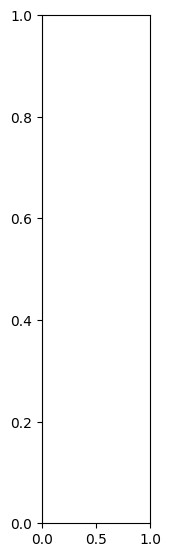

In [60]:
import shap

background_data = shap.sample(X_creditcard_train, 100)

# Create SHAP explainer for the model
explainer = shap.KernelExplainer(cnn_model.predict, background_data)

# Get SHAP values for test data
shap_values = explainer.shap_values(background_data)

# Plot summary of feature importance
shap.summary_plot(shap_values, X_creditcard_test)

  0%|          | 0/100 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 33s 5ms/step


  1%|          | 1/100 [00:48<1:20:33, 48.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 48s 7ms/step


  2%|▏         | 2/100 [02:03<1:44:59, 64.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 42s 6ms/step


  3%|▎         | 3/100 [03:04<1:41:13, 62.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step


  4%|▍         | 4/100 [04:01<1:36:21, 60.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 36s 6ms/step


  5%|▌         | 5/100 [05:00<1:34:40, 59.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step


  6%|▌         | 6/100 [06:28<1:48:56, 69.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step


  7%|▋         | 7/100 [07:19<1:38:26, 63.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step


  8%|▊         | 8/100 [08:19<1:35:38, 62.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 33s 5ms/step


  9%|▉         | 9/100 [09:05<1:27:00, 57.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step


 10%|█         | 10/100 [09:45<1:17:51, 51.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step


 11%|█         | 11/100 [10:42<1:19:00, 53.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 34s 5ms/step


 12%|█▏        | 12/100 [11:31<1:16:16, 52.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step


 13%|█▎        | 13/100 [12:18<1:13:18, 50.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 33s 5ms/step


 14%|█▍        | 14/100 [13:17<1:16:22, 53.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 34s 5ms/step


 15%|█▌        | 15/100 [14:12<1:15:59, 53.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step


 16%|█▌        | 16/100 [15:01<1:13:17, 52.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step


 17%|█▋        | 17/100 [15:38<1:05:50, 47.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step


 18%|█▊        | 18/100 [16:15<1:00:50, 44.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step


 19%|█▉        | 19/100 [16:56<58:42, 43.49s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step


 20%|██        | 20/100 [17:44<59:34, 44.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step


 21%|██        | 21/100 [18:18<54:42, 41.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step


 22%|██▏       | 22/100 [18:47<49:11, 37.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step


 23%|██▎       | 23/100 [19:31<50:43, 39.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step


 24%|██▍       | 24/100 [20:10<50:10, 39.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step


 25%|██▌       | 25/100 [20:56<51:41, 41.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step


 26%|██▌       | 26/100 [21:27<47:22, 38.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step


 27%|██▋       | 27/100 [22:03<45:52, 37.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step


 28%|██▊       | 28/100 [22:34<42:39, 35.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step


 29%|██▉       | 29/100 [23:10<42:15, 35.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 45s 7ms/step


 30%|███       | 30/100 [24:08<49:36, 42.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step


 31%|███       | 31/100 [24:53<49:44, 43.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step


 32%|███▏      | 32/100 [25:36<48:52, 43.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step


 33%|███▎      | 33/100 [26:20<48:25, 43.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 34s 5ms/step


 34%|███▍      | 34/100 [27:06<48:36, 44.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step


 35%|███▌      | 35/100 [27:45<46:08, 42.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 33s 5ms/step


 36%|███▌      | 36/100 [28:31<46:37, 43.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step


 37%|███▋      | 37/100 [29:11<44:41, 42.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step


 38%|███▊      | 38/100 [29:56<44:38, 43.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step


 39%|███▉      | 39/100 [30:37<43:09, 42.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 864ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step


 40%|████      | 40/100 [31:21<43:06, 43.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step


 41%|████      | 41/100 [32:07<43:00, 43.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step


 42%|████▏     | 42/100 [32:46<40:59, 42.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step


 43%|████▎     | 43/100 [33:31<40:58, 43.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step


 44%|████▍     | 44/100 [34:10<39:13, 42.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 34s 5ms/step


 45%|████▌     | 45/100 [34:57<39:42, 43.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 33s 5ms/step


 46%|████▌     | 46/100 [36:21<49:58, 55.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step


 47%|████▋     | 47/100 [36:56<43:42, 49.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step


 48%|████▊     | 48/100 [37:41<41:47, 48.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 33s 5ms/step


 49%|████▉     | 49/100 [38:27<40:22, 47.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step


 50%|█████     | 50/100 [39:08<37:53, 45.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step


 51%|█████     | 51/100 [39:57<38:03, 46.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 38s 6ms/step


 52%|█████▏    | 52/100 [40:50<38:55, 48.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 36s 6ms/step


 53%|█████▎    | 53/100 [41:44<39:17, 50.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step


 54%|█████▍    | 54/100 [42:13<33:30, 43.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step


 55%|█████▌    | 55/100 [42:44<29:57, 39.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step


 56%|█████▌    | 56/100 [43:10<26:15, 35.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step


 57%|█████▋    | 57/100 [43:37<23:44, 33.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step


 58%|█████▊    | 58/100 [44:03<21:41, 30.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step


 59%|█████▉    | 59/100 [44:30<20:21, 29.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step


 60%|██████    | 60/100 [45:04<20:42, 31.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step


 61%|██████    | 61/100 [45:33<19:44, 30.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step


 62%|██████▏   | 62/100 [46:05<19:37, 30.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step


 63%|██████▎   | 63/100 [46:32<18:17, 29.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step


 64%|██████▍   | 64/100 [47:04<18:17, 30.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step


 65%|██████▌   | 65/100 [47:32<17:23, 29.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step


 66%|██████▌   | 66/100 [48:05<17:20, 30.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step


 67%|██████▋   | 67/100 [48:35<16:44, 30.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step


 68%|██████▊   | 68/100 [49:05<16:10, 30.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step


 69%|██████▉   | 69/100 [49:34<15:29, 29.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step


 70%|███████   | 70/100 [50:05<15:11, 30.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step


 71%|███████   | 71/100 [50:40<15:18, 31.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step


 72%|███████▏  | 72/100 [51:08<14:16, 30.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step


 73%|███████▎  | 73/100 [51:34<13:07, 29.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step


 74%|███████▍  | 74/100 [52:06<13:04, 30.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step


 75%|███████▌  | 75/100 [52:34<12:16, 29.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step


 76%|███████▌  | 76/100 [53:18<13:30, 33.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step


 77%|███████▋  | 77/100 [53:49<12:39, 33.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 38s 6ms/step


 78%|███████▊  | 78/100 [54:48<14:52, 40.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 42s 6ms/step


 79%|███████▉  | 79/100 [55:51<16:36, 47.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step


 80%|████████  | 80/100 [56:33<15:14, 45.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step


 81%|████████  | 81/100 [57:21<14:44, 46.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step


 82%|████████▏ | 82/100 [57:53<12:35, 41.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step


 83%|████████▎ | 83/100 [58:21<10:43, 37.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step


 84%|████████▍ | 84/100 [58:47<09:09, 34.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step


 85%|████████▌ | 85/100 [59:13<07:57, 31.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step


 86%|████████▌ | 86/100 [59:43<07:19, 31.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step


 87%|████████▋ | 87/100 [1:00:10<06:28, 29.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step


 88%|████████▊ | 88/100 [1:00:34<05:38, 28.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step


 89%|████████▉ | 89/100 [1:01:02<05:08, 28.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step


 90%|█████████ | 90/100 [1:01:30<04:42, 28.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step


 91%|█████████ | 91/100 [1:01:54<04:01, 26.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step


 92%|█████████▏| 92/100 [1:02:23<03:40, 27.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step


 93%|█████████▎| 93/100 [1:02:50<03:11, 27.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step


 94%|█████████▍| 94/100 [1:03:16<02:40, 26.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step


 95%|█████████▌| 95/100 [1:03:44<02:15, 27.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step


 96%|█████████▌| 96/100 [1:04:08<01:45, 26.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step


 97%|█████████▋| 97/100 [1:04:33<01:17, 25.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step


 98%|█████████▊| 98/100 [1:05:13<01:00, 30.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step


 99%|█████████▉| 99/100 [1:05:41<00:29, 29.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step


100%|██████████| 100/100 [1:06:09<00:00, 39.69s/it]


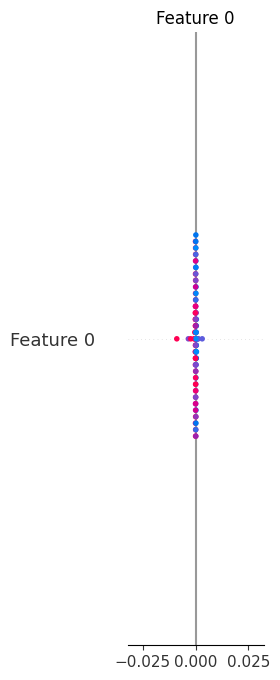

In [61]:
# Compute SHAP values for a smaller test subset
X_creditcard_test_sample = shap.sample(X_creditcard_test, 100)  # Sample 100 rows from the test set
shap_values = explainer.shap_values(X_creditcard_test_sample)

# Plot summary of feature importance
shap.summary_plot(shap_values, X_creditcard_test_sample)

In [53]:
import joblib
from datetime import datetime

# Serialize the model with a timestamp
timestamp = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
cnn_model.save(f"cnn_model_{timestamp}.h5")
joblib.dump(cnn_model, f"cnn_model_{timestamp}.pkl")
joblib.dump(mlp_model, f"mlp_model_{timestamp}.pkl")
joblib.dump(RandomForestClassifier(), f"RandomForestClassifier_{timestamp}.pkl")

['RandomForestClassifier_2024-10-23-13-48-20.pkl']

In [57]:
# Reduce background data to 100 samples using shap.sample
background_data = shap.sample(X_creditcard_train, 50)

In [58]:
# Create SHAP explainer with reduced background data
explainer = shap.KernelExplainer(cnn_model.predict, background_data)

# Compute SHAP values for the test data
shap_values = explainer.shap_values(X_creditcard_test, nsamples=50)  # You can limit the number of samples to avoid memory issues

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


  0%|          | 0/56962 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


  0%|          | 1/56962 [00:02<33:02:31,  2.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step 


  0%|          | 2/56962 [00:04<31:44:50,  2.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


  0%|          | 3/56962 [00:05<30:36:45,  1.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


  0%|          | 4/56962 [00:08<33:04:18,  2.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


  0%|          | 5/56962 [00:09<28:07:29,  1.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


  0%|          | 6/56962 [00:11<27:16:30,  1.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


  0%|          | 7/56962 [00:12<24:42:37,  1.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 8/56962 [00:13<21:10:39,  1.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  0%|          | 9/56962 [00:13<17:38:16,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 10/56962 [00:14<14:56:05,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  0%|          | 11/56962 [00:15<13:55:47,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


  0%|          | 12/56962 [00:15<13:42:10,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 13/56962 [00:17<15:29:10,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 14/56962 [00:18<16:03:08,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 15/56962 [00:18<14:09:08,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  0%|          | 16/56962 [00:19<13:48:55,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 17/56962 [00:20<13:02:16,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 18/56962 [00:21<12:07:25,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 19/56962 [00:21<11:05:24,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 20/56962 [00:22<10:58:34,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 21/56962 [00:22<10:34:32,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 22/56962 [00:23<10:10:24,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 25 iterations, i.e. alpha=2.122e-07, with an active set of 17 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=1.564e-07, with an active set of 20 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressor

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  0%|          | 24/56962 [00:24<9:45:41,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


  0%|          | 25/56962 [00:25<10:43:58,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


  0%|          | 26/56962 [00:26<13:11:11,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  0%|          | 27/56962 [00:27<12:28:36,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 28/56962 [00:27<11:56:37,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 29/56962 [00:28<11:45:07,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 30/56962 [00:29<10:55:20,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  0%|          | 31/56962 [00:30<11:46:53,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 32/56962 [00:30<11:04:17,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


  0%|          | 33/56962 [00:31<13:10:13,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  0%|          | 34/56962 [00:32<12:27:50,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


  0%|          | 35/56962 [00:33<13:32:57,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 36/56962 [00:34<12:03:36,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 37/56962 [00:34<11:39:27,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 38/56962 [00:35<11:42:25,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 39/56962 [00:36<11:14:14,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=3.235e-06, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=1.240e-06, with an active set of 12 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  0%|          | 41/56962 [00:37<13:02:41,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 42/56962 [00:38<11:57:06,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 43/56962 [00:39<11:03:34,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 44/56962 [00:39<10:22:13,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  0%|          | 45/56962 [00:40<11:05:33,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 46/56962 [00:41<10:35:21,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 47/56962 [00:41<10:02:38,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 48/56962 [00:42<9:44:50,  1.62it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 49/56962 [00:42<9:29:12,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  0%|          | 50/56962 [00:43<10:10:12,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 51/56962 [00:44<11:16:03,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 52/56962 [00:45<13:01:45,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 53/56962 [00:46<12:38:08,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 54/56962 [00:46<11:43:49,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  0%|          | 55/56962 [00:47<13:14:17,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 56/56962 [00:48<12:06:45,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 57/56962 [00:49<11:40:53,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 58/56962 [00:49<11:05:43,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 59/56962 [00:50<11:02:30,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 60/56962 [00:51<10:49:39,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 61/56962 [00:51<11:15:00,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 62/56962 [00:52<10:31:25,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  0%|          | 63/56962 [00:53<10:10:01,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  0%|          | 64/56962 [00:53<11:18:43,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 65/56962 [00:54<10:47:04,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.570e-05, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.417e-05, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  0%|          | 67/56962 [00:55<10:23:37,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  0%|          | 68/56962 [00:56<10:33:42,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 69/56962 [00:57<10:10:44,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 70/56962 [00:57<10:01:49,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 71/56962 [00:58<9:52:11,  1.60it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 36 iterations, i.e. alpha=1.517e-07, with an active set of 24 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 36 iterations, i.e. alpha=1.364e-07, with an active set of 24 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
  0%|          | 72/56962 [00:58<9:55:38,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 73/56962 [00:59<9:51:21,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  0%|          | 74/56962 [01:00<10:34:05,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 75/56962 [01:01<12:09:26,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  0%|          | 76/56962 [01:02<12:25:33,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 77/56962 [01:02<11:36:55,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 78/56962 [01:03<10:53:19,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  0%|          | 79/56962 [01:04<11:01:54,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 80/56962 [01:04<11:28:27,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  0%|          | 81/56962 [01:05<11:53:37,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 82/56962 [01:06<11:57:45,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


  0%|          | 83/56962 [01:07<12:27:43,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


  0%|          | 84/56962 [01:08<14:48:36,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 85/56962 [01:09<13:32:40,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  0%|          | 86/56962 [01:10<13:09:34,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  0%|          | 87/56962 [01:10<13:22:48,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


  0%|          | 88/56962 [01:11<13:30:42,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


  0%|          | 89/56962 [01:12<14:11:41,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  0%|          | 90/56962 [01:13<13:57:37,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 91/56962 [01:14<13:20:44,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  0%|          | 92/56962 [01:15<12:22:02,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  0%|          | 93/56962 [01:16<14:48:35,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


  0%|          | 94/56962 [01:18<19:14:06,  1.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


  0%|          | 95/56962 [01:19<18:20:58,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  0%|          | 96/56962 [01:20<17:00:35,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 97/56962 [01:20<15:24:40,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


  0%|          | 98/56962 [01:22<17:08:26,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 99/56962 [01:23<15:51:29,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


  0%|          | 100/56962 [01:23<14:51:33,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=2.879e-05, with an active set of 12 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=1.865e-05, with an active set of 14 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressor

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 102/56962 [01:25<14:42:12,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  0%|          | 103/56962 [01:26<13:49:27,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  0%|          | 104/56962 [01:27<13:15:02,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  0%|          | 105/56962 [01:28<13:34:25,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 106/56962 [01:28<12:17:57,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 107/56962 [01:29<11:55:28,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=7.296e-07, with an active set of 15 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 29 iterations, alpha=3.367e-07, previous alpha=2.442e-07, with an active set of 20 regressors.
  warnings.warn(
  0%|          | 108/56962 [01:30<12:44:21,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  0%|          | 109/56962 [01:31<11:58:13,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 110/56962 [01:31<11:13:29,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  0%|          | 111/56962 [01:32<12:32:38,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 112/56962 [01:33<12:01:08,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 113/56962 [01:33<11:29:31,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  0%|          | 114/56962 [01:35<13:46:10,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  0%|          | 115/56962 [01:36<14:11:45,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  0%|          | 116/56962 [01:36<13:39:55,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 117/56962 [01:37<12:19:17,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  0%|          | 118/56962 [01:38<12:32:18,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  0%|          | 119/56962 [01:39<12:31:43,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  0%|          | 120/56962 [01:39<12:16:01,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  0%|          | 121/56962 [01:40<13:22:11,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  0%|          | 122/56962 [01:41<13:41:09,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  0%|          | 123/56962 [01:42<14:00:22,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 124/56962 [01:43<13:07:15,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=4.495e-05, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 67 iterations, alpha=6.198e-06, previous alpha=2.374e-06, with an active set of 26 regressors.
  warnings.warn(
  0%|          | 125/56962 [01:44<12:33:47,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  0%|          | 126/56962 [01:44<12:06:45,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 127/56962 [01:45<11:27:32,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  0%|          | 128/56962 [01:46<11:24:16,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 129/56962 [01:46<10:54:15,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 130/56962 [01:47<11:34:52,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=1.029e-05, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=5.147e-06, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  0%|          | 132/56962 [01:49<11:21:08,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=3.190e-07, with an active set of 22 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 31 iterations, alpha=2.360e-07, previous alpha=2.020e-07, with an active set of 24 regressors.
  warnings.warn(
  0%|          | 133/56962 [01:49<10:56:29,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 134/56962 [01:50<10:39:23,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 135/56962 [01:50<10:21:22,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 29 iterations, alpha=3.840e-07, previous alpha=3.467e-07, with an active set of 22 regressors.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\shap\explainers\_kernel.py:707: UserWarning: Linear regression equation is singular, a least squares solutions is used instead.
To avoid this situation and get a regular matrix do one of the following:
1) turn up the number of samples,
2) turn up the L1 regularization with num_features(N) where N is less than the number of samples,
3) group features together to reduce the number of inputs that need to be explained.
  warnings.warn(
  0%|          | 136/56962 [01:51<10:38:54,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 137/56962 [01:52<10:39:12,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


  0%|          | 138/56962 [01:53<12:03:48,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  0%|          | 139/56962 [01:54<12:29:51,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 140/56962 [01:54<11:53:03,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  0%|          | 141/56962 [01:55<13:35:25,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 142/56962 [01:56<12:38:18,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 143/56962 [01:57<12:20:24,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=1.241e-04, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=7.175e-05, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 145/56962 [01:58<11:33:03,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 146/56962 [01:59<11:00:45,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 147/56962 [01:59<10:36:54,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


  0%|          | 148/56962 [02:00<10:47:52,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 149/56962 [02:01<11:42:18,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  0%|          | 150/56962 [02:02<11:50:12,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 151/56962 [02:02<11:09:21,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=6.028e-06, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=2.075e-06, with an active set of 9 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early stoppin

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  0%|          | 153/56962 [02:04<11:36:14,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  0%|          | 154/56962 [02:05<12:06:11,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  0%|          | 155/56962 [02:05<12:03:24,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 156/56962 [02:06<11:35:14,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  0%|          | 157/56962 [02:07<12:38:41,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 158/56962 [02:08<13:12:51,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 159/56962 [02:09<12:06:32,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  0%|          | 160/56962 [02:09<12:23:06,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 161/56962 [02:10<13:12:00,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


  0%|          | 162/56962 [02:11<14:26:38,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 163/56962 [02:12<12:58:32,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 164/56962 [02:13<13:22:40,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  0%|          | 165/56962 [02:14<12:17:40,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  0%|          | 166/56962 [02:15<13:28:37,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  0%|          | 167/56962 [02:16<13:37:43,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 168/56962 [02:16<12:32:57,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 169/56962 [02:17<11:38:22,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  0%|          | 170/56962 [02:18<12:19:04,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 171/56962 [02:19<13:27:17,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 172/56962 [02:19<12:10:42,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  0%|          | 173/56962 [02:20<11:57:08,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


  0%|          | 174/56962 [02:21<12:35:24,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  0%|          | 175/56962 [02:22<13:23:24,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 176/56962 [02:23<12:43:03,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  0%|          | 177/56962 [02:23<12:25:45,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 178/56962 [02:24<11:55:31,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 179/56962 [02:25<11:22:08,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 180/56962 [02:25<10:57:55,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


  0%|          | 181/56962 [02:26<11:41:20,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  0%|          | 182/56962 [02:27<11:25:26,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 183/56962 [02:27<10:58:05,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=4.681e-07, with an active set of 20 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 29 iterations, alpha=3.856e-07, previous alpha=3.413e-07, with an active set of 20 regressors.
  warnings.warn(
  0%|          | 184/56962 [02:28<11:27:58,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 185/56962 [02:29<10:34:24,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 186/56962 [02:29<9:54:37,  1.59it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 187/56962 [02:30<9:26:47,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 188/56962 [02:30<8:59:50,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 189/56962 [02:31<9:01:33,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step


  0%|          | 190/56962 [02:45<74:26:36,  4.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  0%|          | 191/56962 [02:46<56:16:53,  3.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


  0%|          | 192/56962 [02:47<44:40:16,  2.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=1.676e-05, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 53 iterations, alpha=1.854e-06, previous alpha=1.831e-06, with an active set of 26 regressors.
  warnings.warn(
  0%|          | 193/56962 [02:48<35:24:43,  2.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 194/56962 [02:49<27:49:40,  1.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  0%|          | 195/56962 [02:51<31:59:46,  2.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  0%|          | 196/56962 [02:53<27:55:32,  1.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 197/56962 [02:54<24:30:55,  1.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


  0%|          | 198/56962 [02:55<21:23:02,  1.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 199/56962 [02:55<18:28:07,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  0%|          | 200/56962 [02:56<16:37:24,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 201/56962 [02:57<14:55:35,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 202/56962 [02:58<13:55:29,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 203/56962 [02:58<13:17:01,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  0%|          | 204/56962 [02:59<12:36:08,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  0%|          | 205/56962 [03:00<12:42:13,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  0%|          | 206/56962 [03:01<14:28:15,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


  0%|          | 207/56962 [03:02<14:55:35,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 208/56962 [03:03<13:32:30,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 209/56962 [03:03<12:37:35,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  0%|          | 210/56962 [03:04<11:59:25,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


  0%|          | 211/56962 [03:05<13:02:52,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 212/56962 [03:06<12:11:52,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  0%|          | 213/56962 [03:06<11:46:04,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 214/56962 [03:07<11:20:12,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  0%|          | 215/56962 [03:08<11:37:51,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 216/56962 [03:08<11:10:54,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 217/56962 [03:09<10:47:34,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 218/56962 [03:10<11:06:02,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  0%|          | 219/56962 [03:10<11:22:45,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  0%|          | 220/56962 [03:11<12:18:28,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 221/56962 [03:12<12:41:56,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  0%|          | 222/56962 [03:13<12:19:19,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  0%|          | 223/56962 [03:14<11:53:47,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 224/56962 [03:14<11:16:52,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 225/56962 [03:15<11:13:14,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 226/56962 [03:16<10:46:30,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


  0%|          | 227/56962 [03:17<12:39:23,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 34 iterations, alpha=3.791e-06, previous alpha=3.475e-06, with an active set of 19 regressors.
  warnings.warn(
  0%|          | 228/56962 [03:17<11:52:35,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


  0%|          | 229/56962 [03:19<14:23:23,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  0%|          | 230/56962 [03:19<13:34:32,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 231/56962 [03:20<13:00:43,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  0%|          | 232/56962 [03:21<12:10:21,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 233/56962 [03:21<11:47:47,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


  0%|          | 234/56962 [03:23<13:20:08,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  0%|          | 235/56962 [03:23<12:47:50,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 236/56962 [03:24<12:00:58,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  0%|          | 237/56962 [03:25<11:52:51,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  0%|          | 238/56962 [03:25<12:08:47,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  0%|          | 239/56962 [03:26<11:41:08,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=3.164e-05, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 41 iterations, alpha=6.901e-07, previous alpha=5.808e-07, with an active set of 22 regressors.
  warnings.warn(
  0%|          | 240/56962 [03:27<11:28:22,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  0%|          | 241/56962 [03:28<11:58:28,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  0%|          | 242/56962 [03:28<12:15:40,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  0%|          | 243/56962 [03:29<12:44:32,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


  0%|          | 244/56962 [03:30<12:50:59,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 245/56962 [03:31<12:18:34,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  0%|          | 246/56962 [03:32<11:49:42,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  0%|          | 247/56962 [03:32<11:53:34,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=5.025e-06, with an active set of 19 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=9.635e-07, with an active set of 22 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressor

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 249/56962 [03:34<12:10:31,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 250/56962 [03:35<11:44:39,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 251/56962 [03:35<10:41:37,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 252/56962 [03:36<11:25:22,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 253/56962 [03:37<10:32:46,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 254/56962 [03:37<9:49:47,  1.60it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 255/56962 [03:38<9:14:54,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 256/56962 [03:38<9:10:14,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 257/56962 [03:39<9:08:04,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 258/56962 [03:39<8:46:23,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 259/56962 [03:40<8:26:03,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 260/56962 [03:40<8:22:29,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 261/56962 [03:41<8:33:15,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  0%|          | 262/56962 [03:42<9:35:11,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 263/56962 [03:42<9:13:47,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=9.644e-06, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 27 iterations, alpha=2.771e-06, previous alpha=1.763e-06, with an active set of 22 regressors.
  warnings.warn(
  0%|          | 264/56962 [03:43<8:51:22,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 265/56962 [03:44<10:46:42,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 266/56962 [03:44<10:04:49,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


  0%|          | 267/56962 [03:45<11:27:44,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 268/56962 [03:46<10:33:19,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=7.898e-06, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 26 iterations, alpha=3.039e-06, previous alpha=1.878e-06, with an active set of 17 regressors.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\shap\explainers\_kernel.py:707: UserWarning: Linear regression equation is singular, a least squares 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 270/56962 [03:47<10:06:31,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  0%|          | 271/56962 [03:48<10:18:01,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 272/56962 [03:48<9:38:13,  1.63it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 273/56962 [03:49<9:21:10,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 274/56962 [03:49<9:57:07,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 275/56962 [03:50<11:20:16,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 276/56962 [03:51<10:26:22,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 277/56962 [03:51<9:39:54,  1.63it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


  0%|          | 278/56962 [03:52<11:49:57,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 279/56962 [03:53<10:54:44,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 280/56962 [03:53<9:58:50,  1.58it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 281/56962 [03:54<9:33:59,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 282/56962 [03:55<9:30:53,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 283/56962 [03:55<9:22:14,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 284/56962 [03:56<9:54:08,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 285/56962 [03:56<10:00:22,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 286/56962 [03:57<10:10:08,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 287/56962 [03:58<9:42:10,  1.62it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 288/56962 [03:58<9:20:21,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 289/56962 [03:59<8:56:14,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 290/56962 [03:59<9:03:53,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=4.924e-06, with an active set of 19 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=3.498e-06, with an active set of 21 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressor

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=9.951e-06, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 34 iterations, i.e. alpha=1.015e-06, with an active set of 18 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 293/56962 [04:01<9:10:42,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 294/56962 [04:02<9:11:54,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 295/56962 [04:02<9:07:52,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 296/56962 [04:03<8:54:44,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 297/56962 [04:03<8:39:40,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 298/56962 [04:04<8:30:30,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 299/56962 [04:04<8:35:38,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 300/56962 [04:05<9:02:02,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 301/56962 [04:05<8:42:12,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 302/56962 [04:06<9:22:44,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=2.010e-06, with an active set of 13 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 28 iterations, alpha=6.893e-07, previous alpha=6.061e-07, with an active set of 21 regressors.
  warnings.warn(
  1%|          | 303/56962 [04:07<9:00:03,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 7 iterations, alpha=1.529e-04, previous alpha=1.529e-04, with an active set of 8 regressors.
  warnings.warn(
  1%|          | 304/56962 [04:07<9:15:17,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 305/56962 [04:08<8:52:38,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 306/56962 [04:08<8:36:34,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 307/56962 [04:09<8:29:28,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 308/56962 [04:09<8:23:03,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 309/56962 [04:10<8:39:53,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 310/56962 [04:10<8:37:04,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 311/56962 [04:11<9:18:46,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 312/56962 [04:12<9:01:49,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 313/56962 [04:12<9:14:36,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=2.626e-07, with an active set of 22 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 30 iterations, alpha=2.404e-07, previous alpha=1.784e-07, with an active set of 23 regressors.
  warnings.warn(
  1%|          | 314/56962 [04:13<9:01:28,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 315/56962 [04:13<8:50:04,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 316/56962 [04:14<8:29:29,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 317/56962 [04:14<8:26:47,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 318/56962 [04:15<8:10:30,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 30 iterations, alpha=9.719e-07, previous alpha=9.559e-07, with an active set of 19 regressors.
  warnings.warn(
  1%|          | 319/56962 [04:16<10:06:31,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=1.852e-06, with an active set of 12 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 41 iterations, alpha=2.883e-07, previous alpha=2.883e-07, with an active set of 22 regressors.
  warnings.warn(
  1%|          | 320/56962 [04:16<10:00:56,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 321/56962 [04:17<10:03:25,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 322/56962 [04:18<9:37:52,  1.63it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 323/56962 [04:18<9:36:56,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 324/56962 [04:19<9:08:03,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 325/56962 [04:19<8:57:09,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=6.203e-06, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=1.345e-06, with an active set of 14 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early stopp

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 327/56962 [04:20<9:16:09,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 328/56962 [04:21<9:10:34,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 329/56962 [04:22<9:05:36,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 330/56962 [04:22<9:33:20,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 331/56962 [04:23<9:19:38,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 332/56962 [04:24<9:34:51,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 333/56962 [04:24<9:08:08,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 334/56962 [04:25<8:48:10,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 335/56962 [04:26<11:48:10,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 336/56962 [04:26<10:49:34,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=1.101e-06, with an active set of 17 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=5.609e-07, with an active set of 20 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early sto

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 338/56962 [04:28<10:37:16,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 339/56962 [04:28<10:05:02,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 340/56962 [04:29<10:01:43,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 341/56962 [04:29<9:27:20,  1.66it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 342/56962 [04:30<9:12:40,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 343/56962 [04:30<9:01:18,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 344/56962 [04:31<8:47:19,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 345/56962 [04:32<9:01:44,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  1%|          | 346/56962 [04:32<9:46:21,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 347/56962 [04:33<9:16:14,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 348/56962 [04:33<8:55:52,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 22 iterations, alpha=1.360e-06, previous alpha=1.354e-06, with an active set of 17 regressors.
  warnings.warn(
  1%|          | 349/56962 [04:34<9:18:40,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 350/56962 [04:34<9:04:40,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 351/56962 [04:35<8:55:18,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 352/56962 [04:36<8:44:27,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 353/56962 [04:36<8:38:00,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 354/56962 [04:37<8:49:15,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 355/56962 [04:37<9:26:37,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 356/56962 [04:38<9:03:06,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 357/56962 [04:38<8:51:33,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 358/56962 [04:39<9:01:31,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 359/56962 [04:40<9:34:16,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 360/56962 [04:40<9:10:00,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 361/56962 [04:41<8:51:41,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 362/56962 [04:41<9:00:05,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 363/56962 [04:42<9:47:12,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 364/56962 [04:43<9:15:51,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 365/56962 [04:43<9:00:41,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 366/56962 [04:44<9:04:46,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 367/56962 [04:44<9:27:38,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 368/56962 [04:45<9:05:06,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 369/56962 [04:45<8:50:47,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=1.128e-06, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=2.594e-07, with an active set of 18 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressor

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 371/56962 [04:47<9:56:00,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 372/56962 [04:47<9:31:52,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 373/56962 [04:48<9:04:12,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 374/56962 [04:48<8:52:39,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 375/56962 [04:49<9:12:22,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 376/56962 [04:50<9:17:59,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 377/56962 [04:50<8:54:52,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 378/56962 [04:51<8:43:04,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 379/56962 [04:51<9:22:26,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 380/56962 [04:52<8:59:36,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 381/56962 [04:52<8:32:05,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 382/56962 [04:53<8:47:28,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=1.792e-07, with an active set of 20 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
  1%|          | 383/56962 [04:53<8:39:32,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 384/56962 [04:54<9:11:12,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 385/56962 [04:55<9:36:20,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  1%|          | 386/56962 [04:56<11:43:00,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 387/56962 [04:57<11:29:02,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 388/56962 [04:57<10:29:36,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 389/56962 [04:58<9:50:10,  1.60it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 390/56962 [04:58<9:58:29,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 391/56962 [04:59<9:34:47,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 392/56962 [04:59<9:14:09,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 393/56962 [05:00<8:54:07,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=1.768e-06, with an active set of 13 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 30 iterations, alpha=4.579e-07, previous alpha=2.742e-07, with an active set of 23 regressors.
  warnings.warn(
  1%|          | 394/56962 [05:00<8:47:49,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  1%|          | 395/56962 [05:01<10:08:43,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 396/56962 [05:02<9:51:11,  1.59it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 397/56962 [05:02<9:27:41,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 398/56962 [05:03<9:01:15,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 399/56962 [05:03<8:52:33,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=2.010e-05, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=9.995e-06, with an active set of 11 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 401/56962 [05:05<8:51:05,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 402/56962 [05:05<8:50:08,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 403/56962 [05:06<9:31:55,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 404/56962 [05:06<9:29:57,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 405/56962 [05:07<9:10:56,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 406/56962 [05:07<8:58:31,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 29 iterations, i.e. alpha=2.731e-07, with an active set of 19 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
  1%|          | 407/56962 [05:08<8:43:28,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 408/56962 [05:09<8:34:11,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 409/56962 [05:09<8:56:47,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


  1%|          | 410/56962 [05:10<9:50:54,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 411/56962 [05:10<9:22:07,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 412/56962 [05:11<8:58:08,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 413/56962 [05:12<9:08:12,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  1%|          | 414/56962 [05:12<10:31:58,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 415/56962 [05:13<10:02:24,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 416/56962 [05:14<10:01:42,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  1%|          | 417/56962 [05:14<10:24:26,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


  1%|          | 418/56962 [05:15<12:33:06,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  1%|          | 419/56962 [05:16<13:01:18,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 420/56962 [05:17<12:32:50,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 421/56962 [05:18<11:28:17,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 422/56962 [05:18<10:33:33,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 423/56962 [05:19<10:04:25,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 424/56962 [05:19<10:01:05,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  1%|          | 425/56962 [05:20<11:15:31,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 426/56962 [05:21<11:04:37,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 427/56962 [05:22<10:19:27,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 428/56962 [05:22<9:36:33,  1.63it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 429/56962 [05:23<9:22:56,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  1%|          | 430/56962 [05:23<9:50:24,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 431/56962 [05:24<9:18:12,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


  1%|          | 432/56962 [05:25<10:05:25,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 433/56962 [05:25<9:32:25,  1.65it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  1%|          | 434/56962 [05:26<11:16:40,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  1%|          | 435/56962 [05:27<11:45:44,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  1%|          | 436/56962 [05:28<11:41:13,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  1%|          | 437/56962 [05:29<13:17:25,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  1%|          | 438/56962 [05:30<13:22:30,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


  1%|          | 439/56962 [05:31<16:06:18,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


  1%|          | 440/56962 [05:32<16:15:42,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 441/56962 [05:33<14:09:28,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  1%|          | 442/56962 [05:33<13:24:41,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  1%|          | 443/56962 [05:34<13:07:27,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 444/56962 [05:35<12:00:04,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 445/56962 [05:35<11:13:55,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 446/56962 [05:36<10:21:02,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=7.643e-06, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=6.884e-06, with an active set of 9 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


  1%|          | 448/56962 [05:38<15:13:40,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  1%|          | 449/56962 [05:40<16:04:23,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


  1%|          | 450/56962 [05:41<19:10:59,  1.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 451/56962 [05:42<16:38:10,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  1%|          | 452/56962 [05:43<15:27:29,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=7.436e-07, with an active set of 18 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 30 iterations, alpha=1.859e-07, previous alpha=1.622e-07, with an active set of 23 regressors.
  warnings.warn(
  1%|          | 453/56962 [05:44<14:54:19,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 454/56962 [05:44<13:21:57,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 455/56962 [05:45<12:38:46,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 456/56962 [05:46<11:56:20,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  1%|          | 457/56962 [05:46<12:28:13,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 458/56962 [05:47<11:28:22,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=4.646e-06, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 34 iterations, i.e. alpha=6.009e-07, with an active set of 18 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


  1%|          | 460/56962 [05:49<14:01:47,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 461/56962 [05:50<13:32:33,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  1%|          | 462/56962 [05:51<13:36:35,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 463/56962 [05:52<13:27:15,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  1%|          | 464/56962 [05:52<13:27:28,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


  1%|          | 465/56962 [05:54<15:40:04,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


  1%|          | 466/56962 [05:55<18:57:06,  1.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 467/56962 [05:56<16:23:57,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 468/56962 [05:57<14:09:58,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  1%|          | 469/56962 [05:57<13:10:49,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 470/56962 [05:58<11:54:51,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 471/56962 [05:59<10:56:13,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 472/56962 [05:59<10:11:39,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 473/56962 [06:00<9:49:52,  1.60it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 474/56962 [06:00<9:43:32,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 475/56962 [06:01<9:25:43,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 476/56962 [06:02<9:59:24,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 477/56962 [06:02<9:43:27,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  1%|          | 478/56962 [06:03<9:50:03,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=1.673e-06, with an active set of 13 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 24 iterations, alpha=4.852e-07, previous alpha=4.828e-07, with an active set of 21 regressors.
  warnings.warn(
  1%|          | 479/56962 [06:03<9:32:37,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 480/56962 [06:04<9:29:29,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 27 iterations, i.e. alpha=2.878e-07, with an active set of 23 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 32 iterations, i.e. alpha=2.473e-07, with an active set of 24 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressor

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 482/56962 [06:05<9:33:07,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 483/56962 [06:06<9:25:34,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 484/56962 [06:06<9:07:31,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  1%|          | 485/56962 [06:07<9:49:27,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=8.145e-07, with an active set of 22 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 25 iterations, i.e. alpha=6.123e-07, with an active set of 23 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early sto

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 12 iterations, alpha=9.166e-06, previous alpha=8.233e-06, with an active set of 13 regressors.
  warnings.warn(
  1%|          | 487/56962 [06:08<9:31:42,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  1%|          | 488/56962 [06:09<9:36:03,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 489/56962 [06:10<10:28:42,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 490/56962 [06:10<10:04:47,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 491/56962 [06:11<9:45:17,  1.61it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 31 iterations, i.e. alpha=6.467e-07, with an active set of 25 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 31 iterations, i.e. alpha=6.373e-07, with an active set of 25 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early sto

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 493/56962 [06:12<9:09:56,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 494/56962 [06:12<8:53:11,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 495/56962 [06:13<10:07:53,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 496/56962 [06:14<9:40:17,  1.62it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 497/56962 [06:15<13:07:40,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 498/56962 [06:16<11:44:20,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 499/56962 [06:16<10:41:29,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 500/56962 [06:17<9:56:49,  1.58it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=1.635e-06, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=1.464e-06, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early stopp

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 502/56962 [06:18<9:46:27,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 503/56962 [06:18<9:17:18,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 504/56962 [06:19<10:01:50,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 505/56962 [06:20<10:04:56,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 506/56962 [06:21<10:21:48,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


  1%|          | 507/56962 [06:22<13:29:54,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 508/56962 [06:22<12:14:00,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 509/56962 [06:23<11:27:01,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 510/56962 [06:24<10:39:28,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  1%|          | 511/56962 [06:24<10:26:57,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 512/56962 [06:25<10:01:47,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  1%|          | 513/56962 [06:26<10:20:00,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 514/56962 [06:26<9:52:15,  1.59it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 515/56962 [06:27<9:33:43,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 516/56962 [06:27<9:04:38,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 517/56962 [06:28<9:01:22,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=8.113e-07, with an active set of 17 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 18 iterations, i.e. alpha=6.656e-07, with an active set of 18 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early sto

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 519/56962 [06:29<9:37:10,  1.63it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.283e-05, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 49 iterations, alpha=1.275e-06, previous alpha=1.021e-06, with an active set of 28 regressors.
  warnings.warn(
  1%|          | 520/56962 [06:30<9:55:17,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 521/56962 [06:30<9:36:05,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 522/56962 [06:31<9:35:06,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  1%|          | 523/56962 [06:32<9:43:11,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 524/56962 [06:32<9:21:03,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 525/56962 [06:33<11:05:02,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 526/56962 [06:34<10:36:24,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 527/56962 [06:34<9:54:10,  1.58it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 528/56962 [06:35<9:20:33,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 529/56962 [06:35<10:01:07,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 530/56962 [06:36<10:00:23,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 531/56962 [06:37<9:29:51,  1.65it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 532/56962 [06:37<9:15:41,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 25 iterations, i.e. alpha=2.551e-07, with an active set of 19 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
  1%|          | 533/56962 [06:38<8:59:49,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 534/56962 [06:38<9:11:14,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 535/56962 [06:39<9:32:49,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=6.790e-07, with an active set of 21 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 24 iterations, alpha=6.790e-07, previous alpha=6.707e-07, with an active set of 21 regressors.
  warnings.warn(
  1%|          | 536/56962 [06:40<9:08:02,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 537/56962 [06:40<9:00:29,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step 


  1%|          | 538/56962 [06:41<12:05:02,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 539/56962 [06:42<11:10:00,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 540/56962 [06:42<10:25:54,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 541/56962 [06:43<10:05:09,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 542/56962 [06:44<9:37:57,  1.63it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=1.757e-05, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=1.081e-05, with an active set of 11 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 544/56962 [06:45<9:15:44,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 545/56962 [06:45<8:58:26,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 546/56962 [06:46<8:48:54,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=4.272e-06, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=2.526e-06, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 548/56962 [06:47<9:49:04,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 549/56962 [06:48<9:29:38,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 550/56962 [06:48<9:08:00,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 551/56962 [06:49<9:16:27,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 552/56962 [06:49<9:12:22,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 553/56962 [06:50<9:05:36,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 554/56962 [06:51<8:51:14,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 555/56962 [06:51<8:51:26,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 556/56962 [06:52<9:15:04,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 557/56962 [06:52<9:57:15,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 558/56962 [06:53<9:27:35,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 559/56962 [06:54<9:07:30,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 560/56962 [06:54<9:25:30,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 561/56962 [06:55<9:21:16,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 562/56962 [06:55<9:01:02,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 563/56962 [06:56<8:48:48,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 564/56962 [06:56<8:46:58,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 565/56962 [06:57<9:16:49,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 566/56962 [06:58<9:04:57,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 567/56962 [06:58<9:52:50,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 568/56962 [06:59<9:30:54,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  1%|          | 569/56962 [07:00<9:47:24,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 570/56962 [07:00<9:24:03,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 571/56962 [07:01<9:15:18,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 572/56962 [07:01<8:57:51,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  1%|          | 573/56962 [07:02<9:30:51,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 574/56962 [07:02<9:25:48,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 575/56962 [07:03<9:08:51,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 576/56962 [07:04<8:49:08,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 577/56962 [07:04<8:46:33,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 578/56962 [07:05<10:15:39,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 579/56962 [07:06<10:32:56,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 580/56962 [07:06<10:06:56,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 581/56962 [07:07<9:34:57,  1.63it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  1%|          | 582/56962 [07:07<9:40:24,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 583/56962 [07:08<9:19:27,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 584/56962 [07:09<9:04:44,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 585/56962 [07:09<8:50:29,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 586/56962 [07:10<8:39:57,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


  1%|          | 587/56962 [07:10<10:16:50,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 588/56962 [07:11<9:40:41,  1.62it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 589/56962 [07:12<9:21:57,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 590/56962 [07:12<9:03:53,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 591/56962 [07:13<9:17:52,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 592/56962 [07:13<9:20:49,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 593/56962 [07:14<9:02:01,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 594/56962 [07:15<9:40:14,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 595/56962 [07:15<10:02:38,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 596/56962 [07:16<10:16:05,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 597/56962 [07:17<9:51:01,  1.59it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 598/56962 [07:17<9:22:35,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 599/56962 [07:18<8:59:18,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 600/56962 [07:18<9:24:45,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 601/56962 [07:19<9:12:03,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 602/56962 [07:20<9:53:31,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 603/56962 [07:20<9:39:47,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 604/56962 [07:21<9:40:09,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 605/56962 [07:21<9:18:59,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 606/56962 [07:22<9:01:14,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 607/56962 [07:22<8:54:23,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 608/56962 [07:23<8:58:14,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 609/56962 [07:24<9:05:43,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\shap\explainers\_kernel.py:707: UserWarning: Linear regression equation is singular, a least squares solutions is used instead.
To avoid this situation and get a regular matrix do one of the following:
1) turn up the number of samples,
2) turn up the L1 regularization with num_features(N) where N is less than the number of samples,
3) group features together to reduce the number of inputs that need to be explained.
  warnings.warn(
  1%|          | 610/56962 [07:24<8:54:24,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 611/56962 [07:25<9:58:15,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 612/56962 [07:26<10:04:33,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 613/56962 [07:26<10:01:25,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 614/56962 [07:27<9:33:49,  1.64it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 615/56962 [07:27<9:16:14,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  1%|          | 616/56962 [07:28<9:25:40,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 617/56962 [07:29<9:39:31,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 618/56962 [07:29<9:18:58,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  1%|          | 619/56962 [07:30<10:00:17,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 620/56962 [07:30<9:27:08,  1.66it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 621/56962 [07:31<9:47:44,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  1%|          | 622/56962 [07:32<9:50:16,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 623/56962 [07:32<9:46:40,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 624/56962 [07:33<9:18:34,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 625/56962 [07:33<9:35:17,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  1%|          | 626/56962 [07:34<9:55:39,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  1%|          | 627/56962 [07:35<10:25:19,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 628/56962 [07:36<11:15:00,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 629/56962 [07:36<10:41:59,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 630/56962 [07:37<9:56:41,  1.57it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 631/56962 [07:37<9:38:42,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 632/56962 [07:38<9:31:15,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  1%|          | 633/56962 [07:39<10:55:46,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  1%|          | 634/56962 [07:40<11:15:22,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 635/56962 [07:40<10:35:56,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  1%|          | 636/56962 [07:41<11:48:51,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 637/56962 [07:42<10:50:20,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 638/56962 [07:42<10:15:07,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 639/56962 [07:43<9:42:57,  1.61it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  1%|          | 640/56962 [07:43<9:45:10,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 641/56962 [07:44<9:33:55,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 642/56962 [07:45<10:17:12,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 643/56962 [07:45<9:56:04,  1.57it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 644/56962 [07:46<10:59:41,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 645/56962 [07:47<10:22:06,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 646/56962 [07:47<9:50:45,  1.59it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\shap\explainers\_kernel.py:707: UserWarning: Linear regression equation is singular, a least squares solutions is used instead.
To avoid this situation and get a regular matrix do one of the following:
1) turn up the number of samples,
2) turn up the L1 regularization with num_features(N) where N is less than the number of samples,
3) group features together to reduce the number of inputs that need to be explained.
  warnings.warn(
  1%|          | 647/56962 [07:48<9:35:34,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  1%|          | 648/56962 [07:49<9:45:44,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 649/56962 [07:49<9:34:18,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 650/56962 [07:50<9:11:42,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 651/56962 [07:50<9:06:18,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  1%|          | 652/56962 [07:51<10:33:39,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 653/56962 [07:52<9:59:39,  1.57it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 654/56962 [07:52<9:29:58,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 655/56962 [07:53<9:04:06,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 656/56962 [07:53<8:51:36,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 657/56962 [07:54<9:16:59,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 658/56962 [07:55<9:06:45,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 659/56962 [07:55<8:57:16,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


  1%|          | 660/56962 [07:56<9:48:01,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 661/56962 [07:57<10:01:57,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 662/56962 [07:57<9:41:43,  1.61it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 663/56962 [07:58<9:21:32,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=4.350e-05, with an active set of 11 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=2.756e-05, with an active set of 13 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressor

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


  1%|          | 665/56962 [07:59<10:40:59,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 666/56962 [08:00<10:05:29,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 667/56962 [08:00<9:30:24,  1.64it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


  1%|          | 668/56962 [08:01<10:00:24,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  1%|          | 669/56962 [08:02<10:25:59,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 670/56962 [08:02<10:15:27,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 671/56962 [08:03<9:45:52,  1.60it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 672/56962 [08:03<9:28:48,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 673/56962 [08:04<9:39:52,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 674/56962 [08:05<9:30:39,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 675/56962 [08:05<9:22:40,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 676/56962 [08:06<10:04:31,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 677/56962 [08:06<9:46:54,  1.60it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 678/56962 [08:07<9:49:55,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 679/56962 [08:08<9:25:35,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 680/56962 [08:08<9:13:24,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 681/56962 [08:09<8:57:42,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 682/56962 [08:10<10:03:51,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 32 iterations, i.e. alpha=6.623e-07, with an active set of 24 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 35 iterations, alpha=5.917e-07, previous alpha=4.241e-07, with an active set of 24 regressors.
  warnings.warn(
  1%|          | 683/56962 [08:10<9:42:54,  1.61it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 684/56962 [08:11<11:39:03,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 685/56962 [08:12<12:03:59,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 686/56962 [08:13<11:02:17,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 687/56962 [08:13<10:26:08,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 688/56962 [08:14<10:08:42,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 689/56962 [08:14<10:16:16,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 690/56962 [08:15<10:02:13,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 691/56962 [08:16<10:31:33,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 692/56962 [08:16<9:58:46,  1.57it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 25 iterations, i.e. alpha=2.346e-07, with an active set of 21 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
  1%|          | 693/56962 [08:17<11:00:14,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 694/56962 [08:18<10:32:46,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 695/56962 [08:18<9:57:09,  1.57it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 696/56962 [08:19<9:35:09,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 697/56962 [08:19<9:16:33,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 698/56962 [08:20<9:32:09,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  1%|          | 699/56962 [08:21<10:31:17,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=1.453e-05, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=6.114e-06, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  1%|          | 701/56962 [08:23<12:16:28,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  1%|          | 702/56962 [08:24<13:21:23,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 703/56962 [08:24<12:07:48,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 704/56962 [08:25<11:13:18,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 705/56962 [08:26<11:11:45,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 706/56962 [08:26<10:24:12,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 707/56962 [08:27<10:38:18,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 708/56962 [08:27<10:20:02,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 709/56962 [08:28<10:03:53,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 710/56962 [08:29<9:32:57,  1.64it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 711/56962 [08:29<9:20:11,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 712/56962 [08:30<9:10:57,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 713/56962 [08:31<11:06:52,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 714/56962 [08:32<12:59:03,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 715/56962 [08:32<11:46:11,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 716/56962 [08:33<11:22:05,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 717/56962 [08:34<10:37:36,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 718/56962 [08:34<10:59:16,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 719/56962 [08:35<10:13:31,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  1%|▏         | 720/56962 [08:36<10:55:26,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 721/56962 [08:36<10:20:49,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 722/56962 [08:37<9:44:28,  1.60it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 723/56962 [08:37<9:52:28,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 724/56962 [08:38<10:31:00,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 725/56962 [08:39<9:58:49,  1.57it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 726/56962 [08:39<9:35:34,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 727/56962 [08:40<9:17:48,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  1%|▏         | 728/56962 [08:41<9:22:10,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 22 iterations, i.e. alpha=3.241e-07, with an active set of 18 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=3.200e-07, with an active set of 19 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressor

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 730/56962 [08:42<9:42:54,  1.61it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 731/56962 [08:42<9:30:10,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 732/56962 [08:43<9:15:20,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 733/56962 [08:44<10:10:25,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 734/56962 [08:44<9:33:41,  1.63it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 735/56962 [08:45<10:14:21,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 736/56962 [08:46<9:52:04,  1.58it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 737/56962 [08:46<10:01:48,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=1.439e-06, with an active set of 15 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 25 iterations, alpha=6.244e-07, previous alpha=5.559e-07, with an active set of 22 regressors.
  warnings.warn(
  1%|▏         | 738/56962 [08:47<9:44:09,  1.60it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 739/56962 [08:47<9:31:19,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


  1%|▏         | 740/56962 [08:48<10:11:12,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 39 iterations, alpha=2.001e-07, previous alpha=2.001e-07, with an active set of 24 regressors.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\shap\explainers\_kernel.py:707: UserWarning: Linear regression equation is singular, a least squares solutions is used instead.
To avoid this situation and get a regular matrix do one of the following:
1) turn up the number of samples,
2) turn up the L1 regularization with num_features(N) where N is less than the number of samples,
3) group features together to reduce the number of inputs that need to be explained.
  warnings.warn(
  1%|▏         | 741/56962 [08:49<10:14:34,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=2.881e-06, with an active set of 11 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=2.039e-06, with an active set of 13 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressor

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 743/56962 [08:50<9:25:50,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 744/56962 [08:51<9:14:20,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  1%|▏         | 745/56962 [08:52<11:19:49,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 746/56962 [08:52<10:22:58,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 747/56962 [08:53<9:58:31,  1.57it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 748/56962 [08:53<9:38:37,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=8.954e-06, with an active set of 15 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 29 iterations, i.e. alpha=8.688e-07, with an active set of 25 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early sto

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


  1%|▏         | 750/56962 [08:55<10:37:25,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 751/56962 [08:55<10:03:20,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 752/56962 [08:56<9:42:12,  1.61it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 753/56962 [08:56<9:25:29,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 754/56962 [08:57<9:42:07,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 755/56962 [08:58<9:21:19,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 22 iterations, i.e. alpha=9.244e-06, with an active set of 20 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 29 iterations, alpha=7.107e-06, previous alpha=7.052e-06, with an active set of 20 regressors.
  warnings.warn(
  1%|▏         | 756/56962 [08:58<10:28:22,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  1%|▏         | 757/56962 [08:59<10:22:22,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 758/56962 [09:00<10:08:43,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 759/56962 [09:00<9:35:27,  1.63it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 760/56962 [09:01<9:25:46,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  1%|▏         | 761/56962 [09:02<11:06:04,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 762/56962 [09:02<10:31:30,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 763/56962 [09:03<9:55:56,  1.57it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 764/56962 [09:03<9:38:29,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 765/56962 [09:04<9:57:29,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 766/56962 [09:05<10:38:28,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 767/56962 [09:06<10:06:29,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 768/56962 [09:06<9:33:42,  1.63it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 769/56962 [09:07<9:50:10,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 770/56962 [09:07<9:45:24,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 771/56962 [09:08<10:19:42,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 772/56962 [09:09<9:58:38,  1.56it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 773/56962 [09:09<9:40:29,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 774/56962 [09:10<10:13:13,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 775/56962 [09:11<9:51:47,  1.58it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 776/56962 [09:11<10:21:53,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 777/56962 [09:12<9:45:46,  1.60it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 18 iterations, alpha=1.442e-06, previous alpha=1.426e-06, with an active set of 17 regressors.
  warnings.warn(
  1%|▏         | 778/56962 [09:12<9:57:25,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 779/56962 [09:13<9:33:18,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 780/56962 [09:14<9:44:42,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 781/56962 [09:14<10:17:08,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  1%|▏         | 782/56962 [09:15<10:38:55,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 783/56962 [09:16<10:21:41,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 784/56962 [09:16<10:29:55,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 785/56962 [09:17<10:23:26,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  1%|▏         | 786/56962 [09:18<13:11:22,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 787/56962 [09:19<12:32:26,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 788/56962 [09:20<12:38:18,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  1%|▏         | 789/56962 [09:21<12:59:48,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


  1%|▏         | 790/56962 [09:22<13:59:36,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  1%|▏         | 791/56962 [09:23<14:42:24,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 792/56962 [09:24<13:48:24,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 793/56962 [09:24<12:13:45,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 794/56962 [09:25<11:03:26,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 795/56962 [09:25<10:36:32,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 796/56962 [09:26<12:07:49,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=1.475e-06, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 35 iterations, alpha=2.369e-07, previous alpha=2.202e-07, with an active set of 20 regressors.
  warnings.warn(
  1%|▏         | 797/56962 [09:27<11:11:51,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 798/56962 [09:27<10:23:16,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 799/56962 [09:28<9:57:40,  1.57it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 800/56962 [09:29<9:34:03,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 801/56962 [09:29<9:13:09,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 802/56962 [09:30<9:41:29,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 803/56962 [09:31<10:24:42,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 804/56962 [09:31<9:55:35,  1.57it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  1%|▏         | 805/56962 [09:33<13:18:16,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  1%|▏         | 806/56962 [09:34<14:41:05,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 807/56962 [09:34<13:45:14,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=5.923e-06, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 28 iterations, alpha=7.056e-07, previous alpha=5.822e-07, with an active set of 21 regressors.
  warnings.warn(
  1%|▏         | 808/56962 [09:35<12:25:06,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 809/56962 [09:36<11:52:14,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 18 iterations, i.e. alpha=7.154e-06, with an active set of 18 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=5.621e-06, with an active set of 19 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early sto

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 811/56962 [09:37<10:29:54,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 812/56962 [09:38<10:51:07,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 813/56962 [09:38<10:22:48,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 814/56962 [09:39<10:24:16,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 815/56962 [09:39<9:58:29,  1.56it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 816/56962 [09:40<9:37:36,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 817/56962 [09:41<10:18:44,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 818/56962 [09:42<10:31:40,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 819/56962 [09:42<10:04:40,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 820/56962 [09:43<9:41:32,  1.61it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 821/56962 [09:43<9:24:37,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


  1%|▏         | 822/56962 [09:44<10:40:27,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 823/56962 [09:45<10:34:04,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  1%|▏         | 824/56962 [09:45<10:38:42,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 825/56962 [09:46<10:09:58,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 826/56962 [09:47<10:03:08,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  1%|▏         | 827/56962 [09:48<11:00:54,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 828/56962 [09:48<10:14:03,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 829/56962 [09:49<9:49:17,  1.59it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 830/56962 [09:49<9:39:43,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 831/56962 [09:50<9:39:06,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 27 iterations, i.e. alpha=4.140e-07, with an active set of 19 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
  1%|▏         | 832/56962 [09:51<10:55:37,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 833/56962 [09:51<10:20:26,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 834/56962 [09:52<9:57:35,  1.57it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 835/56962 [09:52<9:47:16,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 836/56962 [09:53<9:53:09,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  1%|▏         | 837/56962 [09:54<10:38:36,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 838/56962 [09:55<10:29:12,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  1%|▏         | 839/56962 [09:56<13:16:43,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 840/56962 [09:57<12:48:34,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 841/56962 [09:57<11:43:29,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 842/56962 [09:58<12:02:06,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 843/56962 [09:59<13:15:16,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 844/56962 [10:00<12:28:17,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 845/56962 [10:00<11:49:37,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 846/56962 [10:01<11:42:42,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=9.749e-06, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 24 iterations, alpha=1.833e-06, previous alpha=1.757e-06, with an active set of 19 regressors.
  warnings.warn(
  1%|▏         | 847/56962 [10:02<12:32:32,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 848/56962 [10:03<11:36:28,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 849/56962 [10:03<10:54:46,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 850/56962 [10:04<10:13:00,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 851/56962 [10:04<10:26:27,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 852/56962 [10:05<11:02:16,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 853/56962 [10:06<10:25:37,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 854/56962 [10:07<10:33:31,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 855/56962 [10:07<10:28:54,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 856/56962 [10:08<9:58:40,  1.56it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 857/56962 [10:09<10:30:40,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 858/56962 [10:09<10:14:50,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 859/56962 [10:10<10:10:47,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 860/56962 [10:11<10:53:18,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  2%|▏         | 861/56962 [10:12<12:31:37,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 862/56962 [10:12<11:39:16,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 863/56962 [10:13<11:47:39,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 864/56962 [10:14<10:57:28,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 865/56962 [10:14<10:42:04,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 866/56962 [10:15<11:20:52,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 867/56962 [10:16<10:30:56,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 868/56962 [10:16<9:55:46,  1.57it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  2%|▏         | 869/56962 [10:17<10:01:25,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 870/56962 [10:17<9:42:56,  1.60it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=5.042e-05, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=2.521e-05, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early stoppin

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 872/56962 [10:19<10:13:41,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 873/56962 [10:20<10:32:14,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 874/56962 [10:20<9:59:28,  1.56it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 875/56962 [10:21<10:21:58,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 876/56962 [10:22<10:47:08,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 877/56962 [10:22<10:41:43,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 878/56962 [10:23<10:11:39,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=2.889e-06, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=7.567e-07, with an active set of 11 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early stopp

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=2.595e-06, with an active set of 14 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 25 iterations, i.e. alpha=8.579e-07, with an active set of 19 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressor

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 881/56962 [10:25<10:30:27,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 882/56962 [10:26<10:15:03,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 883/56962 [10:26<9:55:41,  1.57it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 884/56962 [10:27<9:45:57,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 885/56962 [10:28<10:45:36,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 886/56962 [10:28<10:10:16,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 887/56962 [10:29<9:48:49,  1.59it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  2%|▏         | 888/56962 [10:29<9:51:17,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 889/56962 [10:30<11:05:29,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 890/56962 [10:31<10:21:02,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 891/56962 [10:31<9:58:15,  1.56it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 892/56962 [10:32<10:02:48,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 893/56962 [10:33<10:09:27,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=5.034e-04, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=4.414e-04, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 895/56962 [10:34<10:28:46,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 896/56962 [10:35<10:26:13,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 897/56962 [10:35<10:12:26,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 898/56962 [10:36<10:38:28,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 899/56962 [10:37<10:10:55,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=9.904e-06, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=2.102e-06, with an active set of 12 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early stopp

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 901/56962 [10:38<9:55:49,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 902/56962 [10:39<9:31:53,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=4.400e-06, with an active set of 14 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 38 iterations, alpha=9.527e-07, previous alpha=4.342e-07, with an active set of 25 regressors.
  warnings.warn(
  2%|▏         | 903/56962 [10:39<10:21:38,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 19 iterations, alpha=6.984e-07, previous alpha=6.875e-07, with an active set of 12 regressors.
  warnings.warn(
  2%|▏         | 904/56962 [10:40<10:11:49,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 905/56962 [10:41<10:19:23,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 906/56962 [10:41<9:52:00,  1.58it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 907/56962 [10:42<10:25:06,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 908/56962 [10:43<10:12:58,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  2%|▏         | 909/56962 [10:43<10:49:43,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 910/56962 [10:44<10:42:40,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 911/56962 [10:45<9:57:31,  1.56it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


  2%|▏         | 912/56962 [10:45<11:20:51,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 913/56962 [10:46<10:47:32,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 914/56962 [10:47<10:13:30,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 915/56962 [10:47<9:42:04,  1.60it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  2%|▏         | 916/56962 [10:48<9:44:32,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=2.249e-05, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=2.103e-05, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 918/56962 [10:49<10:45:55,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 919/56962 [10:50<10:08:12,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 920/56962 [10:51<9:37:39,  1.62it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  2%|▏         | 921/56962 [10:51<10:51:45,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 922/56962 [10:52<10:38:28,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 923/56962 [10:53<9:59:54,  1.56it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 924/56962 [10:53<9:32:05,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 925/56962 [10:54<9:54:15,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 926/56962 [10:55<10:50:33,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 927/56962 [10:55<10:16:17,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 928/56962 [10:56<9:51:34,  1.58it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=9.829e-06, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=1.604e-06, with an active set of 15 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 930/56962 [10:57<10:37:51,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 931/56962 [10:58<10:01:50,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 932/56962 [10:58<9:43:39,  1.60it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 933/56962 [10:59<11:33:14,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 934/56962 [11:00<11:40:03,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 935/56962 [11:01<10:40:56,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 936/56962 [11:01<10:04:52,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  2%|▏         | 937/56962 [11:02<10:09:00,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 938/56962 [11:03<11:09:18,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 939/56962 [11:03<10:43:45,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 940/56962 [11:04<10:03:33,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 941/56962 [11:05<9:56:27,  1.57it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 942/56962 [11:05<10:09:52,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 943/56962 [11:06<10:43:31,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 944/56962 [11:07<10:19:52,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 945/56962 [11:07<10:12:15,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 946/56962 [11:08<10:01:09,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 947/56962 [11:09<10:34:35,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 948/56962 [11:09<9:54:35,  1.57it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 949/56962 [11:10<10:01:08,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 950/56962 [11:10<9:42:17,  1.60it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 951/56962 [11:11<9:27:07,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 952/56962 [11:12<10:09:23,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=2.010e-05, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=8.852e-06, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 954/56962 [11:13<9:51:04,  1.58it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 955/56962 [11:14<9:24:54,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  2%|▏         | 956/56962 [11:14<10:21:01,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 957/56962 [11:15<10:17:08,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 958/56962 [11:16<10:50:27,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 959/56962 [11:16<10:36:54,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  2%|▏         | 960/56962 [11:17<11:01:13,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 961/56962 [11:18<10:43:47,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 962/56962 [11:18<10:15:35,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 963/56962 [11:19<9:49:44,  1.58it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 964/56962 [11:20<9:36:46,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  2%|▏         | 965/56962 [11:21<10:47:04,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 966/56962 [11:21<10:10:19,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 967/56962 [11:22<9:48:23,  1.59it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 968/56962 [11:22<9:25:53,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 969/56962 [11:23<9:57:44,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 970/56962 [11:24<10:35:35,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 971/56962 [11:24<10:40:44,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 972/56962 [11:25<10:44:36,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 973/56962 [11:26<13:12:19,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 974/56962 [11:27<13:35:45,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  2%|▏         | 975/56962 [11:28<13:41:07,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=3.828e-06, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=2.968e-06, with an active set of 9 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 977/56962 [11:30<13:46:03,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 978/56962 [11:31<13:05:47,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  2%|▏         | 979/56962 [11:31<12:15:46,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 980/56962 [11:32<11:46:21,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 981/56962 [11:33<10:59:18,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  2%|▏         | 982/56962 [11:33<11:13:24,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\shap\explainers\_kernel.py:707: UserWarning: Linear regression equation is singular, a least squares solutions is used instead.
To avoid this situation and get a regular matrix do one of the following:
1) turn up the number of samples,
2) turn up the L1 regularization with num_features(N) where N is less than the number of samples,
3) group features together to reduce the number of inputs that need to be explained.
  warnings.warn(
  2%|▏         | 983/56962 [11:34<10:57:57,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 984/56962 [11:35<10:20:45,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 985/56962 [11:35<9:53:05,  1.57it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 986/56962 [11:36<9:29:10,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 987/56962 [11:37<10:24:19,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 988/56962 [11:37<10:20:01,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 989/56962 [11:38<10:01:47,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 990/56962 [11:38<9:32:54,  1.63it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


  2%|▏         | 991/56962 [11:39<10:28:36,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  2%|▏         | 992/56962 [11:40<10:51:41,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 993/56962 [11:41<11:39:16,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 994/56962 [11:41<10:51:33,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 995/56962 [11:42<10:14:54,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 996/56962 [11:43<11:12:47,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 997/56962 [11:43<10:25:31,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 998/56962 [11:44<9:53:50,  1.57it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 999/56962 [11:44<9:31:10,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  2%|▏         | 1000/56962 [11:45<10:45:20,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1001/56962 [11:46<10:30:47,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1002/56962 [11:47<10:04:46,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1003/56962 [11:47<9:39:22,  1.61it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=2.019e-05, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=1.003e-05, with an active set of 9 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors i

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  2%|▏         | 1005/56962 [11:49<11:11:22,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=9.251e-05, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=3.888e-05, with an active set of 17 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early stopp

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1007/56962 [11:50<10:04:00,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\shap\explainers\_kernel.py:707: UserWarning: Linear regression equation is singular, a least squares solutions is used instead.
To avoid this situation and get a regular matrix do one of the following:
1) turn up the number of samples,
2) turn up the L1 regularization with num_features(N) where N is less than the number of samples,
3) group features together to reduce the number of inputs that need to be explained.
  warnings.warn(
  2%|▏         | 1008/56962 [11:50<9:34:36,  1.62it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


  2%|▏         | 1009/56962 [11:51<10:48:20,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  2%|▏         | 1010/56962 [11:52<10:42:41,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1011/56962 [11:53<10:12:52,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1012/56962 [11:53<9:51:13,  1.58it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1013/56962 [11:54<9:41:15,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  2%|▏         | 1014/56962 [11:55<10:53:57,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1015/56962 [11:55<10:20:21,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1016/56962 [11:56<9:52:41,  1.57it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1017/56962 [11:56<9:38:44,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  2%|▏         | 1018/56962 [11:57<11:21:38,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1019/56962 [11:58<10:36:56,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1020/56962 [11:58<10:09:29,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1021/56962 [11:59<9:48:58,  1.58it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1022/56962 [12:00<10:43:44,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1023/56962 [12:01<11:07:48,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1024/56962 [12:01<10:25:14,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1025/56962 [12:02<10:13:49,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1026/56962 [12:03<11:08:00,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1027/56962 [12:03<10:39:26,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1028/56962 [12:04<10:03:23,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1029/56962 [12:04<9:36:43,  1.62it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1030/56962 [12:05<10:25:06,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1031/56962 [12:06<10:27:56,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1032/56962 [12:06<10:00:47,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1033/56962 [12:07<9:38:24,  1.61it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  2%|▏         | 1034/56962 [12:08<10:49:22,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1035/56962 [12:09<10:38:47,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1036/56962 [12:09<10:16:29,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1037/56962 [12:10<9:53:18,  1.57it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1038/56962 [12:11<10:53:55,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1039/56962 [12:11<10:55:38,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1040/56962 [12:12<10:26:06,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=1.445e-04, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 36 iterations, i.e. alpha=1.574e-05, with an active set of 20 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1042/56962 [12:14<11:58:17,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1043/56962 [12:14<11:10:26,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=1.236e-05, with an active set of 12 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=9.551e-06, with an active set of 15 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early sto

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1045/56962 [12:15<10:33:35,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


  2%|▏         | 1046/56962 [12:16<11:49:20,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1047/56962 [12:17<10:49:01,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1048/56962 [12:18<10:24:46,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1049/56962 [12:18<9:54:53,  1.57it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=8.013e-07, with an active set of 15 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 32 iterations, alpha=2.944e-07, previous alpha=2.465e-07, with an active set of 23 regressors.
  warnings.warn(
  2%|▏         | 1050/56962 [12:19<10:49:52,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1051/56962 [12:19<10:19:06,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1052/56962 [12:20<9:56:25,  1.56it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1053/56962 [12:21<9:30:23,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1054/56962 [12:21<10:31:55,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1055/56962 [12:22<10:24:21,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1056/56962 [12:23<10:10:20,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1057/56962 [12:23<9:42:48,  1.60it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1058/56962 [12:24<9:29:03,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1059/56962 [12:25<10:47:24,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1060/56962 [12:25<10:21:41,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1061/56962 [12:26<10:13:28,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1062/56962 [12:27<9:44:40,  1.59it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=8.752e-07, with an active set of 17 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=7.119e-07, with an active set of 18 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressor

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1064/56962 [12:28<10:32:20,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1065/56962 [12:29<10:58:52,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1066/56962 [12:29<10:32:25,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  2%|▏         | 1067/56962 [12:30<11:22:31,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1068/56962 [12:31<10:43:19,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1069/56962 [12:31<10:12:41,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1070/56962 [12:32<10:09:20,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=1.992e-06, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=1.371e-06, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1072/56962 [12:34<10:38:13,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1073/56962 [12:34<10:22:50,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1074/56962 [12:35<9:57:53,  1.56it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  2%|▏         | 1075/56962 [12:36<10:54:21,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1076/56962 [12:36<10:41:59,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1077/56962 [12:37<10:09:06,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1078/56962 [12:37<9:43:55,  1.60it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  2%|▏         | 1079/56962 [12:38<10:38:55,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1080/56962 [12:39<10:50:14,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1081/56962 [12:40<10:43:41,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=8.068e-06, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=3.553e-06, with an active set of 17 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressor

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1083/56962 [12:41<11:10:29,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  2%|▏         | 1084/56962 [12:42<11:43:05,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1085/56962 [12:43<11:50:31,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  2%|▏         | 1086/56962 [12:43<11:32:53,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


  2%|▏         | 1087/56962 [12:44<12:26:42,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1088/56962 [12:45<11:37:01,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1089/56962 [12:46<10:57:12,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1090/56962 [12:46<10:39:46,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1091/56962 [12:47<11:20:31,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1092/56962 [12:48<10:33:26,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1093/56962 [12:48<9:55:50,  1.56it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1094/56962 [12:49<9:41:54,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=8.413e-06, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=3.092e-06, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early stopp

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1096/56962 [12:50<10:24:21,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1097/56962 [12:51<10:37:06,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1098/56962 [12:52<10:09:13,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=4.221e-07, with an active set of 20 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
  2%|▏         | 1099/56962 [12:53<11:27:51,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1100/56962 [12:53<10:45:39,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1101/56962 [12:54<10:05:35,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1102/56962 [12:54<9:56:08,  1.56it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


  2%|▏         | 1103/56962 [12:55<11:22:49,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1104/56962 [12:56<10:42:13,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1105/56962 [12:56<10:22:28,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  2%|▏         | 1106/56962 [12:57<10:45:51,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  2%|▏         | 1107/56962 [12:58<11:59:19,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1108/56962 [12:59<11:13:17,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1109/56962 [12:59<10:41:09,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 31 iterations, alpha=2.791e-07, previous alpha=2.791e-07, with an active set of 20 regressors.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\shap\explainers\_kernel.py:707: UserWarning: Linear regression equation is singular, a least squares solutions is used instead.
To avoid this situation and get a regular matrix do one of the following:
1) turn up the number of samples,
2) turn up the L1 regularization with num_features(N) where N is less than the number of samples,
3) group features together to reduce the number of inputs that need to be explained.
  warnings.warn(
  2%|▏         | 1110/56962 [13:00<10:13:10,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


  2%|▏         | 1111/56962 [13:01<11:29:27,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1112/56962 [13:02<10:56:20,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1113/56962 [13:02<10:37:23,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1114/56962 [13:03<10:10:22,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  2%|▏         | 1115/56962 [13:04<11:21:13,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1116/56962 [13:04<10:45:57,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1117/56962 [13:05<10:13:30,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1118/56962 [13:05<9:47:31,  1.58it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  2%|▏         | 1119/56962 [13:06<10:55:37,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1120/56962 [13:07<10:49:28,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1121/56962 [13:08<10:21:25,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1122/56962 [13:08<10:12:01,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  2%|▏         | 1123/56962 [13:09<10:59:04,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1124/56962 [13:10<10:35:07,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1125/56962 [13:10<10:31:37,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1126/56962 [13:11<10:01:54,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1127/56962 [13:12<10:57:32,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1128/56962 [13:12<10:56:37,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1129/56962 [13:13<10:27:15,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1130/56962 [13:14<9:57:59,  1.56it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  2%|▏         | 1131/56962 [13:14<11:07:22,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1132/56962 [13:15<11:01:22,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1133/56962 [13:16<10:43:23,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1134/56962 [13:16<10:11:39,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  2%|▏         | 1135/56962 [13:17<11:26:01,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1136/56962 [13:18<10:43:23,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1137/56962 [13:18<10:09:00,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1138/56962 [13:19<10:08:34,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  2%|▏         | 1139/56962 [13:20<11:36:12,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1140/56962 [13:21<10:54:44,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1141/56962 [13:21<10:25:18,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1142/56962 [13:22<10:04:51,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1143/56962 [13:23<11:19:36,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1144/56962 [13:23<10:46:00,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1145/56962 [13:24<10:05:21,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1146/56962 [13:25<9:43:08,  1.60it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  2%|▏         | 1147/56962 [13:25<11:03:14,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1148/56962 [13:26<10:37:54,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1149/56962 [13:27<10:08:53,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1150/56962 [13:27<9:49:49,  1.58it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1151/56962 [13:28<11:00:43,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1152/56962 [13:29<10:28:05,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1153/56962 [13:29<10:03:42,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1154/56962 [13:30<9:46:20,  1.59it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  2%|▏         | 1155/56962 [13:31<11:19:40,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1156/56962 [13:31<10:42:16,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1157/56962 [13:32<10:26:09,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1158/56962 [13:33<10:04:55,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1159/56962 [13:34<11:21:49,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1160/56962 [13:34<10:37:58,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1161/56962 [13:35<10:14:06,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 42 iterations, alpha=6.651e-07, previous alpha=6.651e-07, with an active set of 19 regressors.
  warnings.warn(
  2%|▏         | 1162/56962 [13:35<9:56:32,  1.56it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1163/56962 [13:36<11:22:57,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1164/56962 [13:37<10:42:12,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1165/56962 [13:38<10:31:01,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=1.078e-05, with an active set of 12 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=9.155e-06, with an active set of 14 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressor

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  2%|▏         | 1167/56962 [13:39<12:02:14,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1168/56962 [13:40<11:11:25,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1169/56962 [13:40<10:27:50,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1170/56962 [13:41<9:58:02,  1.55it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=1.218e-04, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 27 iterations, alpha=3.546e-05, previous alpha=1.016e-05, with an active set of 22 regressors.
  warnings.warn(
  2%|▏         | 1171/56962 [13:42<11:28:30,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1172/56962 [13:43<10:51:00,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1173/56962 [13:43<10:13:05,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1174/56962 [13:44<10:39:38,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1175/56962 [13:45<11:41:45,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1176/56962 [13:45<10:50:54,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1177/56962 [13:46<10:27:34,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 21 iterations, alpha=6.781e-07, previous alpha=6.638e-07, with an active set of 18 regressors.
  warnings.warn(
  2%|▏         | 1178/56962 [13:47<10:07:26,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1179/56962 [13:47<10:40:35,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1180/56962 [13:48<10:26:23,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1181/56962 [13:49<10:19:50,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=2.966e-06, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 22 iterations, i.e. alpha=5.733e-07, with an active set of 18 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressor

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1183/56962 [13:50<10:39:28,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1184/56962 [13:51<10:11:30,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1185/56962 [13:51<10:16:00,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1186/56962 [13:52<10:46:37,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1187/56962 [13:53<10:17:10,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1188/56962 [13:53<10:17:47,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  2%|▏         | 1189/56962 [13:54<10:12:37,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1190/56962 [13:55<10:51:40,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1191/56962 [13:55<10:14:07,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1192/56962 [13:56<10:04:30,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=3.454e-06, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 52 iterations, alpha=4.390e-07, previous alpha=4.252e-07, with an active set of 27 regressors.
  warnings.warn(
  2%|▏         | 1193/56962 [13:57<11:20:59,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1194/56962 [13:58<10:42:07,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1195/56962 [13:58<10:16:47,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 27 iterations, i.e. alpha=1.147e-06, with an active set of 19 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 28 iterations, alpha=1.147e-06, previous alpha=1.145e-06, with an active set of 19 regressors.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\shap\explainers\_kernel.py:707: UserWarning: Linear regression equation is singular, a least square

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1197/56962 [14:00<11:22:15,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1198/56962 [14:00<10:48:46,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1199/56962 [14:01<10:06:56,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


  2%|▏         | 1200/56962 [14:02<10:46:52,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1201/56962 [14:02<11:09:05,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1202/56962 [14:03<10:34:53,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1203/56962 [14:04<10:10:36,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


  2%|▏         | 1204/56962 [14:04<11:12:33,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1205/56962 [14:05<11:02:39,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1206/56962 [14:06<10:28:22,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1207/56962 [14:06<9:58:35,  1.55it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1208/56962 [14:07<10:30:32,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1209/56962 [14:08<10:41:28,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1210/56962 [14:08<10:14:38,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1211/56962 [14:09<10:41:32,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1212/56962 [14:10<10:18:54,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1213/56962 [14:10<10:32:44,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1214/56962 [14:11<10:19:05,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1215/56962 [14:12<10:54:10,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1216/56962 [14:13<10:34:36,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1217/56962 [14:13<10:59:49,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1218/56962 [14:14<10:27:06,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1219/56962 [14:15<11:08:12,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  2%|▏         | 1220/56962 [14:15<11:12:16,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1221/56962 [14:16<11:11:53,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1222/56962 [14:17<10:36:53,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1223/56962 [14:18<10:59:41,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1224/56962 [14:18<11:05:49,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1225/56962 [14:19<10:28:52,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  2%|▏         | 1226/56962 [14:20<11:13:37,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1227/56962 [14:20<10:44:54,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1228/56962 [14:21<10:46:11,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1229/56962 [14:22<11:30:31,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  2%|▏         | 1230/56962 [14:23<11:49:46,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1231/56962 [14:23<11:15:46,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1232/56962 [14:24<11:08:52,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1233/56962 [14:25<11:23:13,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1234/56962 [14:25<11:03:44,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  2%|▏         | 1235/56962 [14:26<11:12:55,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1236/56962 [14:27<10:38:47,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1237/56962 [14:28<12:10:52,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1238/56962 [14:28<11:30:18,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  2%|▏         | 1239/56962 [14:29<11:51:31,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  2%|▏         | 1240/56962 [14:30<11:51:04,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1241/56962 [14:31<13:00:39,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  2%|▏         | 1242/56962 [14:32<13:12:56,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  2%|▏         | 1243/56962 [14:33<12:51:58,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1244/56962 [14:34<12:49:52,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1245/56962 [14:35<14:00:10,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 33 iterations, alpha=1.214e-06, previous alpha=1.140e-06, with an active set of 22 regressors.
  warnings.warn(
  2%|▏         | 1246/56962 [14:35<12:26:10,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1247/56962 [14:36<11:31:35,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1248/56962 [14:37<11:52:00,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1249/56962 [14:38<12:19:18,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1250/56962 [14:38<11:23:21,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1251/56962 [14:39<10:59:47,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  2%|▏         | 1252/56962 [14:40<13:47:45,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


  2%|▏         | 1253/56962 [14:41<15:58:04,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


  2%|▏         | 1254/56962 [14:42<15:39:49,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  2%|▏         | 1255/56962 [14:43<14:45:49,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


  2%|▏         | 1256/56962 [14:44<16:06:43,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1257/56962 [14:45<14:12:50,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1258/56962 [14:46<13:03:26,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1259/56962 [14:46<12:26:55,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1260/56962 [14:47<12:21:24,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1261/56962 [14:48<13:09:30,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  2%|▏         | 1262/56962 [14:49<13:12:06,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


  2%|▏         | 1263/56962 [14:50<14:25:05,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=6.948e-05, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=9.546e-06, with an active set of 15 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  2%|▏         | 1265/56962 [14:52<12:38:05,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1266/56962 [14:52<11:40:44,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1267/56962 [14:53<12:03:35,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1268/56962 [14:54<11:13:21,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1269/56962 [14:54<11:18:31,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1270/56962 [14:55<11:32:04,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1271/56962 [14:56<10:51:51,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1272/56962 [14:56<10:29:53,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  2%|▏         | 1273/56962 [14:57<10:38:54,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1274/56962 [14:58<11:19:41,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1275/56962 [14:59<10:46:57,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1276/56962 [14:59<10:17:22,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1277/56962 [15:00<10:32:15,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1278/56962 [15:01<10:59:54,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1279/56962 [15:01<10:44:18,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  2%|▏         | 1280/56962 [15:02<10:59:40,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


  2%|▏         | 1281/56962 [15:03<11:53:09,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1282/56962 [15:04<11:08:40,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1283/56962 [15:04<10:37:28,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  2%|▏         | 1284/56962 [15:05<10:38:16,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1285/56962 [15:06<11:05:27,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1286/56962 [15:06<10:29:56,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1287/56962 [15:07<10:08:31,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 3 iterations, alpha=9.142e-06, previous alpha=8.490e-06, with an active set of 4 regressors.
  warnings.warn(
  2%|▏         | 1288/56962 [15:08<11:20:57,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1289/56962 [15:08<10:54:39,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1290/56962 [15:09<10:18:28,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1291/56962 [15:10<10:02:27,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


  2%|▏         | 1292/56962 [15:11<11:38:15,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1293/56962 [15:11<11:02:53,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1294/56962 [15:12<10:32:15,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1295/56962 [15:12<10:08:37,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1296/56962 [15:13<11:28:15,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1297/56962 [15:14<10:50:09,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1298/56962 [15:15<10:12:05,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  2%|▏         | 1299/56962 [15:15<11:27:47,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1300/56962 [15:16<11:28:05,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1301/56962 [15:17<10:47:09,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1302/56962 [15:17<10:23:57,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  2%|▏         | 1303/56962 [15:18<12:08:35,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 25 iterations, i.e. alpha=2.199e-07, with an active set of 21 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
  2%|▏         | 1304/56962 [15:19<12:04:02,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  2%|▏         | 1305/56962 [15:20<13:40:02,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1306/56962 [15:21<13:23:35,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1307/56962 [15:22<14:20:42,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1308/56962 [15:23<13:28:43,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1309/56962 [15:24<13:32:13,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


  2%|▏         | 1310/56962 [15:25<14:56:08,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1311/56962 [15:26<14:06:36,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1312/56962 [15:27<13:04:06,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1313/56962 [15:27<12:12:10,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=1.728e-05, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=1.775e-06, with an active set of 17 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early stopp

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  2%|▏         | 1315/56962 [15:29<14:30:09,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1316/56962 [15:30<12:59:30,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  2%|▏         | 1317/56962 [15:31<13:37:39,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  2%|▏         | 1318/56962 [15:32<12:48:19,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1319/56962 [15:32<11:52:49,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1320/56962 [15:33<11:24:32,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


  2%|▏         | 1321/56962 [15:34<14:46:14,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=1.451e-06, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=7.896e-07, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1323/56962 [15:36<12:05:49,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1324/56962 [15:37<12:10:37,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  2%|▏         | 1325/56962 [15:37<12:25:06,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=4.789e-06, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=4.354e-06, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1327/56962 [15:39<11:07:53,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=1.425e-04, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 29 iterations, i.e. alpha=2.205e-05, with an active set of 19 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressor

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  2%|▏         | 1329/56962 [15:41<13:12:16,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=9.909e-07, with an active set of 13 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
  2%|▏         | 1330/56962 [15:42<13:24:42,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


  2%|▏         | 1331/56962 [15:43<13:50:17,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  2%|▏         | 1332/56962 [15:43<12:56:50,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  2%|▏         | 1333/56962 [15:44<12:43:23,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1334/56962 [15:45<12:05:15,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


  2%|▏         | 1335/56962 [15:46<13:08:13,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1336/56962 [15:47<13:17:12,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1337/56962 [15:47<12:33:02,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1338/56962 [15:48<11:44:35,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1339/56962 [15:49<12:17:37,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1340/56962 [15:49<11:40:34,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1341/56962 [15:50<10:58:29,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1342/56962 [15:51<10:55:37,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1343/56962 [15:51<10:56:48,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


  2%|▏         | 1344/56962 [15:52<10:58:03,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1345/56962 [15:53<10:28:13,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  2%|▏         | 1346/56962 [15:54<11:07:05,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  2%|▏         | 1347/56962 [15:55<11:52:56,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1348/56962 [15:55<11:35:00,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1349/56962 [15:56<11:22:43,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  2%|▏         | 1350/56962 [15:57<11:54:21,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1351/56962 [15:57<11:18:51,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1352/56962 [15:58<11:35:06,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1353/56962 [15:59<10:51:03,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1354/56962 [16:00<11:19:19,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1355/56962 [16:00<10:52:39,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1356/56962 [16:01<10:56:13,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1357/56962 [16:02<10:39:07,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1358/56962 [16:02<11:18:46,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1359/56962 [16:03<11:05:30,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1360/56962 [16:04<11:20:55,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  2%|▏         | 1361/56962 [16:05<11:54:40,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1362/56962 [16:05<11:08:43,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 32 iterations, i.e. alpha=3.475e-07, with an active set of 22 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
  2%|▏         | 1363/56962 [16:06<11:55:35,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1364/56962 [16:07<11:07:35,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1365/56962 [16:08<11:36:31,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1366/56962 [16:08<11:14:17,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1367/56962 [16:09<11:03:12,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  2%|▏         | 1368/56962 [16:10<11:46:31,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1369/56962 [16:11<11:00:38,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1370/56962 [16:11<10:59:53,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1371/56962 [16:12<10:35:12,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1372/56962 [16:13<11:02:47,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1373/56962 [16:13<10:34:50,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1374/56962 [16:14<10:43:52,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


  2%|▏         | 1375/56962 [16:15<12:23:25,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1376/56962 [16:16<11:27:34,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1377/56962 [16:16<11:03:40,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1378/56962 [16:17<10:54:54,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1379/56962 [16:18<11:23:48,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1380/56962 [16:18<10:46:28,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  2%|▏         | 1381/56962 [16:19<10:39:46,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1382/56962 [16:20<11:13:30,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1383/56962 [16:20<10:51:59,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1384/56962 [16:21<10:37:58,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1385/56962 [16:22<11:02:35,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1386/56962 [16:23<11:18:59,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1387/56962 [16:23<10:39:45,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1388/56962 [16:24<10:21:00,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1389/56962 [16:25<11:24:36,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1390/56962 [16:25<11:02:18,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1391/56962 [16:27<16:48:54,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1392/56962 [16:28<14:36:25,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1393/56962 [16:29<13:00:54,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1394/56962 [16:29<12:06:44,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1395/56962 [16:30<12:35:14,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=1.184e-04, with an active set of 11 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 38 iterations, i.e. alpha=1.638e-05, with an active set of 20 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early sto

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1397/56962 [16:31<11:13:53,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=5.844e-05, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 36 iterations, alpha=2.261e-07, previous alpha=2.261e-07, with an active set of 25 regressors.
  warnings.warn(
  2%|▏         | 1398/56962 [16:32<12:13:33,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1399/56962 [16:33<11:53:00,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1400/56962 [16:34<11:03:32,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1401/56962 [16:34<10:36:42,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1402/56962 [16:35<11:31:00,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=2.376e-06, with an active set of 19 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 28 iterations, alpha=1.318e-06, previous alpha=1.022e-06, with an active set of 23 regressors.
  warnings.warn(
  2%|▏         | 1403/56962 [16:36<11:43:02,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1404/56962 [16:37<11:02:59,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1405/56962 [16:37<10:18:17,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  2%|▏         | 1406/56962 [16:38<12:19:02,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1407/56962 [16:39<11:33:07,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1408/56962 [16:39<10:40:38,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1409/56962 [16:40<11:11:14,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1410/56962 [16:41<11:14:16,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1411/56962 [16:42<10:35:49,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1412/56962 [16:42<10:59:50,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1413/56962 [16:43<10:56:47,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1414/56962 [16:44<12:01:56,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1415/56962 [16:45<11:12:58,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1416/56962 [16:45<11:42:04,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  2%|▏         | 1417/56962 [16:46<11:19:54,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1418/56962 [16:47<10:48:03,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1419/56962 [16:48<11:13:16,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1420/56962 [16:48<10:29:06,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1421/56962 [16:49<10:16:44,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1422/56962 [16:49<10:28:54,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1423/56962 [16:50<11:04:24,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1424/56962 [16:51<10:35:45,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1425/56962 [16:52<10:29:14,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1426/56962 [16:52<10:37:51,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1427/56962 [16:53<11:07:02,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1428/56962 [16:54<10:36:54,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1429/56962 [16:54<10:40:51,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1430/56962 [16:55<10:34:40,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1431/56962 [16:56<11:05:35,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1432/56962 [16:57<11:00:35,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1433/56962 [16:57<10:42:05,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1434/56962 [16:58<12:10:56,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1435/56962 [16:59<11:22:06,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1436/56962 [16:59<11:06:57,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


  3%|▎         | 1437/56962 [17:00<12:05:52,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1438/56962 [17:01<11:17:26,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1439/56962 [17:02<11:00:49,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1440/56962 [17:02<10:47:27,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1441/56962 [17:03<11:41:54,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1442/56962 [17:04<10:57:13,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1443/56962 [17:04<10:27:31,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1444/56962 [17:05<11:55:03,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1445/56962 [17:06<11:19:17,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1446/56962 [17:07<10:55:31,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1447/56962 [17:08<11:46:03,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1448/56962 [17:08<11:39:55,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1449/56962 [17:09<11:00:04,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1450/56962 [17:10<11:18:41,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1451/56962 [17:11<11:26:41,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1452/56962 [17:11<10:49:44,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1453/56962 [17:12<10:27:06,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1454/56962 [17:13<10:59:17,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1455/56962 [17:13<10:39:56,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1456/56962 [17:14<10:43:22,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1457/56962 [17:15<10:48:59,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1458/56962 [17:15<11:01:36,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1459/56962 [17:16<11:16:47,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1460/56962 [17:17<10:55:45,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1461/56962 [17:18<11:39:06,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1462/56962 [17:18<11:01:37,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1463/56962 [17:19<11:08:13,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1464/56962 [17:20<11:14:02,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1465/56962 [17:21<11:41:34,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1466/56962 [17:21<10:58:14,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1467/56962 [17:22<10:56:49,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1468/56962 [17:23<11:26:00,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1469/56962 [17:23<10:42:29,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1470/56962 [17:24<10:59:02,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1471/56962 [17:25<11:45:50,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1472/56962 [17:26<11:19:02,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1473/56962 [17:26<11:58:51,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


  3%|▎         | 1474/56962 [17:27<12:32:50,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1475/56962 [17:28<11:30:34,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1476/56962 [17:29<10:48:40,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1477/56962 [17:29<11:08:25,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1478/56962 [17:30<11:37:49,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1479/56962 [17:31<11:04:44,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1480/56962 [17:31<10:24:39,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1481/56962 [17:32<12:02:55,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1482/56962 [17:33<11:32:21,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1483/56962 [17:34<10:54:53,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1484/56962 [17:35<11:27:54,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1485/56962 [17:35<11:23:47,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1486/56962 [17:36<10:42:31,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1487/56962 [17:37<11:17:32,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1488/56962 [17:37<10:49:43,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1489/56962 [17:38<10:43:41,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1490/56962 [17:39<11:15:26,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1491/56962 [17:40<11:25:45,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1492/56962 [17:40<12:13:24,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1493/56962 [17:41<12:35:38,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1494/56962 [17:42<11:46:19,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1495/56962 [17:43<11:12:13,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


  3%|▎         | 1496/56962 [17:44<13:13:59,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\shap\explainers\_kernel.py:707: UserWarning: Linear regression equation is singular, a least squares solutions is used instead.
To avoid this situation and get a regular matrix do one of the following:
1) turn up the number of samples,
2) turn up the L1 regularization with num_features(N) where N is less than the number of samples,
3) group features together to reduce the number of inputs that need to be explained.
  warnings.warn(
  3%|▎         | 1497/56962 [17:45<14:50:55,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1498/56962 [17:46<13:35:05,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1499/56962 [17:47<14:12:14,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1500/56962 [17:47<13:04:43,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1501/56962 [17:48<12:17:07,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1502/56962 [17:49<12:57:56,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1503/56962 [17:50<12:10:57,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1504/56962 [17:50<11:20:24,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1505/56962 [17:51<11:54:08,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1506/56962 [17:52<12:07:17,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1507/56962 [17:53<11:17:09,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1508/56962 [17:53<11:43:51,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1509/56962 [17:54<11:11:46,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1510/56962 [17:55<11:09:38,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1511/56962 [17:56<11:38:04,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1512/56962 [17:56<11:01:41,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1513/56962 [17:57<11:07:00,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1514/56962 [17:58<11:53:26,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1515/56962 [17:58<11:07:38,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1516/56962 [17:59<10:39:44,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


  3%|▎         | 1517/56962 [18:00<11:53:17,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1518/56962 [18:01<11:18:36,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1519/56962 [18:01<10:43:06,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1520/56962 [18:02<11:38:26,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1521/56962 [18:03<11:49:18,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1522/56962 [18:04<11:03:24,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1523/56962 [18:04<11:32:43,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1524/56962 [18:05<10:49:41,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1525/56962 [18:06<10:58:25,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1526/56962 [18:07<11:28:55,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1527/56962 [18:07<11:46:27,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1528/56962 [18:08<11:32:44,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1529/56962 [18:09<13:08:46,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1530/56962 [18:10<12:09:52,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=1.837e-05, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=1.215e-05, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1532/56962 [18:12<12:50:50,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=5.901e-06, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 20 iterations, alpha=2.402e-06, previous alpha=2.112e-06, with an active set of 15 regressors.
  warnings.warn(
  3%|▎         | 1533/56962 [18:12<11:56:06,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1534/56962 [18:13<11:09:40,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


  3%|▎         | 1535/56962 [18:14<12:15:19,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1536/56962 [18:14<11:49:24,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1537/56962 [18:15<11:12:03,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1538/56962 [18:16<11:57:08,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1539/56962 [18:17<11:49:34,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1540/56962 [18:17<11:04:34,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1541/56962 [18:18<11:32:59,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 24 iterations, alpha=2.346e-06, previous alpha=2.339e-06, with an active set of 15 regressors.
  warnings.warn(
  3%|▎         | 1542/56962 [18:19<11:35:38,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1543/56962 [18:20<10:56:36,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1544/56962 [18:20<11:21:52,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1545/56962 [18:21<10:52:13,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1546/56962 [18:22<10:49:11,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1547/56962 [18:23<11:36:32,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1548/56962 [18:23<11:01:55,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1549/56962 [18:24<10:36:45,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


  3%|▎         | 1550/56962 [18:25<11:55:32,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1551/56962 [18:26<12:24:03,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1552/56962 [18:26<12:38:55,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1553/56962 [18:28<13:55:30,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1554/56962 [18:29<14:09:34,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1555/56962 [18:29<12:47:10,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1556/56962 [18:30<12:10:04,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1557/56962 [18:31<13:08:48,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1558/56962 [18:32<13:27:34,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1559/56962 [18:32<12:43:08,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1560/56962 [18:33<13:26:48,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1561/56962 [18:34<12:17:01,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1562/56962 [18:35<12:20:05,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1563/56962 [18:36<12:40:03,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1564/56962 [18:36<12:06:44,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1565/56962 [18:37<11:49:35,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1566/56962 [18:38<12:15:20,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1567/56962 [18:39<11:59:57,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1568/56962 [18:39<11:30:05,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1569/56962 [18:40<12:37:02,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1570/56962 [18:41<12:11:39,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1571/56962 [18:42<11:24:55,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1572/56962 [18:42<10:47:15,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1573/56962 [18:43<11:14:39,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1574/56962 [18:44<11:17:47,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1575/56962 [18:45<10:46:37,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1576/56962 [18:45<11:26:47,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1577/56962 [18:46<10:59:35,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1578/56962 [18:47<10:55:37,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1579/56962 [18:48<11:26:37,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1580/56962 [18:48<10:57:33,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1581/56962 [18:49<11:12:28,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1582/56962 [18:50<11:48:06,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1583/56962 [18:50<11:01:58,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1584/56962 [18:51<10:45:39,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1585/56962 [18:52<12:08:45,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1586/56962 [18:53<11:26:48,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1587/56962 [18:53<10:52:44,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1588/56962 [18:54<11:17:16,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1589/56962 [18:55<11:56:50,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1590/56962 [18:56<11:08:12,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=1.013e-05, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=6.075e-06, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=9.932e-06, with an active set of 15 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 18 iterations, i.e. alpha=9.780e-06, with an active set of 16 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early sto

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1593/56962 [18:58<11:37:45,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1594/56962 [18:59<11:54:49,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.856e-05, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=7.608e-06, with an active set of 15 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1596/56962 [19:00<11:26:46,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1597/56962 [19:01<12:02:58,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1598/56962 [19:02<11:28:10,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1599/56962 [19:02<10:54:07,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


  3%|▎         | 1600/56962 [19:03<11:55:37,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1601/56962 [19:04<11:16:10,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1602/56962 [19:05<10:54:35,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1603/56962 [19:06<11:32:26,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1604/56962 [19:06<11:32:29,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1605/56962 [19:07<11:04:18,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1606/56962 [19:08<11:38:38,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1607/56962 [19:08<11:24:50,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1608/56962 [19:09<11:11:23,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


  3%|▎         | 1609/56962 [19:10<11:44:00,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1610/56962 [19:11<11:05:38,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1611/56962 [19:11<11:48:07,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1612/56962 [19:12<12:10:33,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1613/56962 [19:13<11:37:31,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1614/56962 [19:14<11:40:01,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 4 iterations, alpha=1.144e-05, previous alpha=1.117e-05, with an active set of 5 regressors.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\shap\explainers\_kernel.py:707: UserWarning: Linear regression equation is singular, a least squares solutions is used instead.
To avoid this situation and get a regular matrix do one of the following:
1) turn up the number of samples,
2) turn up the L1 regularization with num_features(N) where N is less than the number of samples,
3) group features together to reduce the number of inputs that need to be explained.
  warnings.warn(
  3%|▎         | 1615/56962 [19:15<12:08:17,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1616/56962 [19:15<11:37:06,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1617/56962 [19:16<11:01:19,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=8.308e-06, with an active set of 14 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 22 iterations, alpha=9.411e-06, previous alpha=4.465e-06, with an active set of 17 regressors.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\shap\explainers\_kernel.py:707: UserWarning: Linear regression equation is singular, a least square

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1619/56962 [19:18<11:20:20,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1620/56962 [19:18<10:53:31,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1621/56962 [19:19<11:33:08,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1622/56962 [19:20<12:07:14,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1623/56962 [19:21<11:25:34,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1624/56962 [19:21<11:52:34,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1625/56962 [19:22<11:38:18,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1626/56962 [19:23<11:37:39,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


  3%|▎         | 1627/56962 [19:24<12:33:23,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1628/56962 [19:24<11:39:22,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1629/56962 [19:25<11:05:30,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1630/56962 [19:26<11:10:15,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=1.759e-05, with an active set of 9 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=8.570e-06, with an active set of 13 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early stopp

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1632/56962 [19:27<10:56:14,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1633/56962 [19:28<11:09:18,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 24 iterations, alpha=3.805e-06, previous alpha=3.420e-06, with an active set of 17 regressors.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\shap\explainers\_kernel.py:707: UserWarning: Linear regression equation is singular, a least squares solutions is used instead.
To avoid this situation and get a regular matrix do one of the following:
1) turn up the number of samples,
2) turn up the L1 regularization with num_features(N) where N is less than the number of samples,
3) group features together to reduce the number of inputs that need to be explained.
  warnings.warn(
  3%|▎         | 1634/56962 [19:29<12:05:49,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1635/56962 [19:30<11:20:09,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1636/56962 [19:30<11:25:35,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1637/56962 [19:31<12:09:47,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1638/56962 [19:32<11:43:52,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1639/56962 [19:33<11:18:22,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1640/56962 [19:33<12:05:00,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1641/56962 [19:34<11:33:55,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1642/56962 [19:35<10:57:17,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=7.717e-07, with an active set of 18 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
  3%|▎         | 1643/56962 [19:36<11:53:07,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1644/56962 [19:36<11:30:48,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1645/56962 [19:37<10:59:41,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1646/56962 [19:38<11:05:24,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1647/56962 [19:39<11:27:04,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=1.362e-06, with an active set of 12 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
  3%|▎         | 1648/56962 [19:39<10:54:32,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1649/56962 [19:40<10:34:57,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1650/56962 [19:41<11:09:01,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1651/56962 [19:42<12:14:51,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1652/56962 [19:42<11:22:03,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


  3%|▎         | 1653/56962 [19:43<11:45:57,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1654/56962 [19:44<11:08:04,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1655/56962 [19:44<11:03:50,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1656/56962 [19:45<11:54:53,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1657/56962 [19:46<11:22:57,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1658/56962 [19:47<11:22:24,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1659/56962 [19:47<11:44:15,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1660/56962 [19:48<11:03:45,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1661/56962 [19:49<10:40:01,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1662/56962 [19:50<12:42:56,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1663/56962 [19:50<11:44:45,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1664/56962 [19:51<11:05:05,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1665/56962 [19:52<11:33:03,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1666/56962 [19:53<11:27:41,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1667/56962 [19:53<10:58:19,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1668/56962 [19:54<11:26:46,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1669/56962 [19:55<10:48:06,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1670/56962 [19:55<10:59:40,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1671/56962 [19:56<11:30:29,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=1.850e-06, with an active set of 18 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 22 iterations, i.e. alpha=1.611e-06, with an active set of 20 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressor

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1673/56962 [19:58<10:58:55,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1674/56962 [19:59<11:55:26,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1675/56962 [19:59<11:11:57,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1676/56962 [20:00<10:42:22,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


  3%|▎         | 1677/56962 [20:01<11:46:22,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1678/56962 [20:01<11:18:28,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 35 iterations, i.e. alpha=3.103e-06, with an active set of 21 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 35 iterations, i.e. alpha=2.502e-06, with an active set of 21 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early sto

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1680/56962 [20:03<11:43:20,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=1.505e-06, with an active set of 22 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
  3%|▎         | 1681/56962 [20:04<11:38:16,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1682/56962 [20:04<11:03:45,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1683/56962 [20:05<11:32:11,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1684/56962 [20:06<11:21:08,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1685/56962 [20:07<10:54:00,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1686/56962 [20:07<11:35:02,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1687/56962 [20:08<11:22:03,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1688/56962 [20:09<11:22:36,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1689/56962 [20:10<11:46:59,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1690/56962 [20:10<11:12:03,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1691/56962 [20:11<10:52:47,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=9.334e-06, with an active set of 11 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 23 iterations, alpha=2.376e-06, previous alpha=2.029e-06, with an active set of 20 regressors.
  warnings.warn(
  3%|▎         | 1692/56962 [20:12<11:56:59,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1693/56962 [20:13<11:07:45,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1694/56962 [20:13<10:42:37,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


  3%|▎         | 1695/56962 [20:14<11:47:40,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1696/56962 [20:15<11:15:23,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1697/56962 [20:16<11:28:44,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1698/56962 [20:16<12:04:35,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=9.353e-06, with an active set of 13 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=8.276e-06, with an active set of 14 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressor

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1700/56962 [20:18<11:25:43,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1701/56962 [20:19<12:06:01,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1702/56962 [20:20<12:22:13,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 24 iterations, alpha=1.003e-06, previous alpha=1.003e-06, with an active set of 17 regressors.
  warnings.warn(
  3%|▎         | 1703/56962 [20:20<11:33:26,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1704/56962 [20:21<12:02:08,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1705/56962 [20:22<11:47:20,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1706/56962 [20:23<11:33:14,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1707/56962 [20:23<11:58:22,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1708/56962 [20:24<11:14:46,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1709/56962 [20:25<11:05:35,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1710/56962 [20:26<11:54:10,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1711/56962 [20:26<11:19:46,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1712/56962 [20:27<11:13:35,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1713/56962 [20:28<12:06:14,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1714/56962 [20:28<11:23:54,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1715/56962 [20:29<10:59:24,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1716/56962 [20:30<11:48:45,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1717/56962 [20:31<12:02:44,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1718/56962 [20:32<11:22:31,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


  3%|▎         | 1719/56962 [20:32<11:56:45,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1720/56962 [20:33<11:40:03,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1721/56962 [20:34<11:19:48,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


  3%|▎         | 1722/56962 [20:35<11:59:41,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1723/56962 [20:35<11:32:48,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1724/56962 [20:36<11:34:50,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


  3%|▎         | 1725/56962 [20:37<11:52:59,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1726/56962 [20:38<11:10:35,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 36 iterations, alpha=1.057e-06, previous alpha=1.057e-06, with an active set of 25 regressors.
  warnings.warn(
  3%|▎         | 1727/56962 [20:38<10:52:58,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=1.680e-06, with an active set of 18 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 28 iterations, alpha=7.667e-07, previous alpha=5.721e-07, with an active set of 21 regressors.
  warnings.warn(
  3%|▎         | 1728/56962 [20:39<11:59:18,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1729/56962 [20:40<11:21:39,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1730/56962 [20:40<10:49:46,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


  3%|▎         | 1731/56962 [20:41<12:12:33,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1732/56962 [20:42<11:47:07,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1733/56962 [20:43<11:11:55,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1734/56962 [20:44<11:55:57,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1735/56962 [20:44<11:57:54,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1736/56962 [20:45<11:19:03,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1737/56962 [20:46<11:48:26,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1738/56962 [20:47<11:35:41,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=2.506e-06, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
  3%|▎         | 1739/56962 [20:47<11:08:42,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1740/56962 [20:48<11:41:10,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1741/56962 [20:51<21:34:40,  1.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1742/56962 [20:52<18:56:47,  1.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1743/56962 [20:53<16:02:45,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1744/56962 [20:53<15:20:54,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=2.665e-05, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 27 iterations, i.e. alpha=4.196e-06, with an active set of 17 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early stopp

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1746/56962 [20:55<12:53:28,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1747/56962 [20:56<12:55:30,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1748/56962 [20:56<12:06:29,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1749/56962 [20:57<12:20:31,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1750/56962 [20:58<12:25:32,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1751/56962 [20:59<11:34:02,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1752/56962 [20:59<10:58:28,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1753/56962 [21:00<11:47:09,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1754/56962 [21:01<11:09:02,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\shap\explainers\_kernel.py:707: UserWarning: Linear regression equation is singular, a least squares solutions is used instead.
To avoid this situation and get a regular matrix do one of the following:
1) turn up the number of samples,
2) turn up the L1 regularization with num_features(N) where N is less than the number of samples,
3) group features together to reduce the number of inputs that need to be explained.
  warnings.warn(
  3%|▎         | 1755/56962 [21:01<10:28:18,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1756/56962 [21:02<11:47:04,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1757/56962 [21:03<12:55:56,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1758/56962 [21:04<12:00:04,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1759/56962 [21:05<12:48:55,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1760/56962 [21:06<12:21:23,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1761/56962 [21:06<11:34:05,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1762/56962 [21:07<12:40:33,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1763/56962 [21:08<12:20:50,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1764/56962 [21:09<12:03:22,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1765/56962 [21:10<13:20:08,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1766/56962 [21:11<12:29:54,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1767/56962 [21:11<11:51:41,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1768/56962 [21:12<12:32:07,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1769/56962 [21:13<11:39:59,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1770/56962 [21:13<11:01:29,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1771/56962 [21:14<12:05:09,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1772/56962 [21:15<12:03:03,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1773/56962 [21:16<12:44:41,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1774/56962 [21:17<12:40:01,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1775/56962 [21:18<11:55:01,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1776/56962 [21:18<11:48:53,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1777/56962 [21:19<11:58:49,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1778/56962 [21:20<11:34:42,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1779/56962 [21:21<11:34:54,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


  3%|▎         | 1780/56962 [21:21<11:58:09,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=1.046e-06, with an active set of 17 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=5.123e-07, with an active set of 20 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early sto

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1782/56962 [21:23<11:48:37,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1783/56962 [21:24<12:06:44,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1784/56962 [21:24<11:25:52,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1785/56962 [21:25<11:13:48,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1786/56962 [21:26<12:18:58,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1787/56962 [21:27<11:27:53,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1788/56962 [21:27<10:56:47,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1789/56962 [21:28<12:32:24,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 18 iterations, i.e. alpha=1.072e-06, with an active set of 14 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 53 iterations, alpha=1.969e-07, previous alpha=1.504e-07, with an active set of 28 regressors.
  warnings.warn(
  3%|▎         | 1790/56962 [21:29<11:39:04,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1791/56962 [21:30<11:08:03,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


  3%|▎         | 1792/56962 [21:31<12:05:18,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1793/56962 [21:31<12:20:35,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1794/56962 [21:32<12:04:04,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1795/56962 [21:33<12:28:58,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1796/56962 [21:34<12:14:40,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1797/56962 [21:34<11:27:06,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1798/56962 [21:35<11:51:31,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1799/56962 [21:36<11:09:40,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1800/56962 [21:37<12:01:17,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1801/56962 [21:38<12:37:28,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1802/56962 [21:38<11:39:15,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


  3%|▎         | 1803/56962 [21:39<13:04:04,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1804/56962 [21:40<11:57:29,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1805/56962 [21:41<11:28:43,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


  3%|▎         | 1806/56962 [21:42<12:28:31,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1807/56962 [21:42<11:49:20,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1808/56962 [21:43<11:11:24,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


  3%|▎         | 1809/56962 [21:44<11:41:50,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1810/56962 [21:44<11:25:33,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1811/56962 [21:45<10:55:57,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 31 iterations, i.e. alpha=4.046e-07, with an active set of 19 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 32 iterations, i.e. alpha=4.041e-07, with an active set of 20 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressor

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1813/56962 [21:47<11:02:00,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1814/56962 [21:48<11:59:43,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1815/56962 [21:48<12:20:08,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1816/56962 [21:49<11:40:34,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=1.111e-06, with an active set of 18 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=9.780e-07, with an active set of 19 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early sto

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1818/56962 [21:51<12:10:16,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1819/56962 [21:51<11:21:49,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1820/56962 [21:52<11:51:56,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1821/56962 [21:53<11:51:16,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1822/56962 [21:54<11:23:32,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1823/56962 [21:54<11:40:32,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1824/56962 [21:55<11:03:12,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1825/56962 [21:56<11:09:50,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1826/56962 [21:57<11:46:52,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=8.916e-06, with an active set of 12 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 51 iterations, alpha=9.962e-07, previous alpha=9.962e-07, with an active set of 24 regressors.
  warnings.warn(
  3%|▎         | 1827/56962 [21:57<11:09:26,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


  3%|▎         | 1828/56962 [21:59<13:10:14,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1829/56962 [21:59<12:22:44,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=2.025e-06, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=1.703e-06, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early stopp

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1831/56962 [22:01<11:56:33,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1832/56962 [22:01<11:42:09,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


  3%|▎         | 1833/56962 [22:02<12:57:39,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1834/56962 [22:03<11:53:48,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1835/56962 [22:04<11:30:25,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1836/56962 [22:05<12:41:31,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1837/56962 [22:05<11:32:32,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1838/56962 [22:06<11:01:54,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1839/56962 [22:07<12:16:52,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1840/56962 [22:08<11:38:12,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1841/56962 [22:08<11:07:01,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1842/56962 [22:09<11:39:43,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1843/56962 [22:10<11:38:12,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1844/56962 [22:11<11:51:58,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1845/56962 [22:12<12:22:42,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1846/56962 [22:12<12:06:35,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1847/56962 [22:13<12:12:12,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1848/56962 [22:14<12:02:31,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1849/56962 [22:14<11:15:27,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=3.994e-05, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=3.539e-05, with an active set of 11 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early sto

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1851/56962 [22:16<11:36:17,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1852/56962 [22:17<11:04:00,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1853/56962 [22:18<11:51:48,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1854/56962 [22:18<11:32:35,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1855/56962 [22:19<12:16:36,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1856/56962 [22:20<11:31:17,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1857/56962 [22:21<11:27:26,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1858/56962 [22:21<11:55:23,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1859/56962 [22:22<11:20:28,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1860/56962 [22:23<11:01:04,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1861/56962 [22:24<11:58:45,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1862/56962 [22:24<11:17:44,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 23 iterations, alpha=1.702e-05, previous alpha=1.671e-05, with an active set of 20 regressors.
  warnings.warn(
  3%|▎         | 1863/56962 [22:25<12:29:33,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1864/56962 [22:26<12:19:20,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1865/56962 [22:27<11:45:27,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1866/56962 [22:28<13:47:54,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1867/56962 [22:29<13:17:58,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1868/56962 [22:30<13:41:06,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1869/56962 [22:30<12:41:30,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1870/56962 [22:31<11:48:44,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1871/56962 [22:32<13:11:58,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1872/56962 [22:33<12:25:27,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1873/56962 [22:34<12:17:55,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1874/56962 [22:34<11:50:05,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1875/56962 [22:35<11:42:50,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1876/56962 [22:36<12:17:36,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1877/56962 [22:37<11:29:09,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1878/56962 [22:37<11:20:50,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1879/56962 [22:38<12:08:35,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1880/56962 [22:39<11:25:48,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1881/56962 [22:40<11:52:52,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1882/56962 [22:41<12:26:04,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1883/56962 [22:41<11:42:45,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1884/56962 [22:42<12:21:16,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1885/56962 [22:43<13:06:44,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


  3%|▎         | 1886/56962 [22:44<14:34:47,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1887/56962 [22:45<14:04:58,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1888/56962 [22:46<13:08:07,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1889/56962 [22:47<13:38:11,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


  3%|▎         | 1890/56962 [22:49<19:06:33,  1.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1891/56962 [22:50<17:25:27,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


  3%|▎         | 1892/56962 [22:51<17:52:34,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1893/56962 [22:52<17:24:01,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1894/56962 [22:53<16:22:49,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1895/56962 [22:54<14:49:10,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1896/56962 [22:55<13:48:19,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1897/56962 [22:55<13:37:18,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1898/56962 [22:56<12:21:27,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1899/56962 [22:57<11:50:19,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1900/56962 [22:58<12:39:31,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1901/56962 [22:58<11:47:04,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1902/56962 [22:59<12:30:44,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1903/56962 [23:00<12:41:14,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1904/56962 [23:01<11:48:22,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


  3%|▎         | 1905/56962 [23:02<12:08:22,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1906/56962 [23:02<12:03:16,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1907/56962 [23:03<11:56:48,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1908/56962 [23:04<12:15:18,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1909/56962 [23:05<11:30:27,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1910/56962 [23:05<11:25:35,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1911/56962 [23:06<12:16:51,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1912/56962 [23:07<11:31:21,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1913/56962 [23:08<11:40:04,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1914/56962 [23:09<12:24:06,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1915/56962 [23:09<12:05:15,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


  3%|▎         | 1916/56962 [23:10<12:58:01,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1917/56962 [23:11<13:32:31,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1918/56962 [23:12<13:14:35,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=2.571e-04, with an active set of 13 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 35 iterations, alpha=1.834e-05, previous alpha=1.756e-05, with an active set of 24 regressors.
  warnings.warn(
  3%|▎         | 1919/56962 [23:13<13:11:31,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1920/56962 [23:14<12:30:38,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1921/56962 [23:14<11:48:29,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1922/56962 [23:15<13:02:28,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=8.343e-06, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=3.314e-06, with an active set of 11 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1924/56962 [23:17<11:36:51,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1925/56962 [23:18<12:25:39,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1926/56962 [23:18<11:58:01,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1927/56962 [23:19<12:25:42,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1928/56962 [23:20<11:35:54,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1929/56962 [23:21<11:41:21,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1930/56962 [23:22<12:42:01,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1931/56962 [23:22<11:49:52,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1932/56962 [23:23<12:22:48,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1933/56962 [23:24<12:13:24,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1934/56962 [23:25<11:29:48,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1935/56962 [23:26<12:07:46,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1936/56962 [23:26<11:49:07,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1937/56962 [23:27<11:24:47,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1938/56962 [23:28<11:49:38,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1939/56962 [23:29<11:39:33,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


  3%|▎         | 1940/56962 [23:29<12:29:13,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1941/56962 [23:30<11:56:59,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1942/56962 [23:31<11:16:36,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=5.858e-06, with an active set of 12 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=4.799e-06, with an active set of 15 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early sto

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1944/56962 [23:32<11:39:59,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1945/56962 [23:33<12:11:20,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1946/56962 [23:34<12:24:23,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1947/56962 [23:35<12:27:28,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


  3%|▎         | 1948/56962 [23:36<13:01:52,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1949/56962 [23:37<12:10:12,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=6.971e-05, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=6.715e-05, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 29 iterations, i.e. alpha=1.282e-07, with an active set of 23 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 30 iterations, alpha=1.280e-07, previous alpha=1.247e-07, with an active set of 23 regressors.
  warnings.warn(
  3%|▎         | 1951/56962 [23:38<11:40:33,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1952/56962 [23:39<11:38:37,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


  3%|▎         | 1953/56962 [23:40<12:06:18,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 32 iterations, alpha=5.903e-07, previous alpha=5.111e-07, with an active set of 21 regressors.
  warnings.warn(
  3%|▎         | 1954/56962 [23:40<11:25:53,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1955/56962 [23:41<11:25:42,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1956/56962 [23:42<12:11:11,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1957/56962 [23:43<11:44:32,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1958/56962 [23:43<12:21:36,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1959/56962 [23:44<12:22:41,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1960/56962 [23:45<12:07:09,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1961/56962 [23:46<12:21:32,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1962/56962 [23:47<12:12:36,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1963/56962 [23:48<12:39:10,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1964/56962 [23:48<11:52:55,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1965/56962 [23:49<11:34:04,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1966/56962 [23:50<12:26:10,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1967/56962 [23:51<11:34:37,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1968/56962 [23:51<12:14:49,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1969/56962 [23:52<12:09:32,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1970/56962 [23:53<11:30:08,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1971/56962 [23:54<11:58:27,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1972/56962 [23:54<11:30:28,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1973/56962 [23:55<11:25:02,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1974/56962 [23:56<13:11:49,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1975/56962 [23:57<12:37:01,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=6.623e-06, with an active set of 14 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 17 iterations, alpha=6.207e-06, previous alpha=5.265e-06, with an active set of 16 regressors.
  warnings.warn(
  3%|▎         | 1976/56962 [23:58<12:54:22,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1977/56962 [23:59<13:15:45,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1978/56962 [23:59<12:10:25,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


  3%|▎         | 1979/56962 [24:00<12:33:42,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 21 iterations, alpha=2.611e-07, previous alpha=2.572e-07, with an active set of 18 regressors.
  warnings.warn(
  3%|▎         | 1980/56962 [24:01<12:26:05,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1981/56962 [24:02<11:55:55,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


  3%|▎         | 1982/56962 [24:03<12:22:12,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1983/56962 [24:04<12:20:07,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1984/56962 [24:04<11:35:54,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1985/56962 [24:05<12:02:07,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1986/56962 [24:06<11:31:00,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1987/56962 [24:07<12:27:45,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1988/56962 [24:07<11:55:41,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1989/56962 [24:08<11:19:02,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


  3%|▎         | 1990/56962 [24:09<13:04:22,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1991/56962 [24:10<12:53:43,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 1992/56962 [24:11<12:26:24,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  3%|▎         | 1993/56962 [24:12<15:04:04,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▎         | 1994/56962 [24:14<17:21:34,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=8.737e-05, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=7.913e-05, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early stoppin

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▎         | 1996/56962 [24:15<15:23:35,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▎         | 1997/56962 [24:16<13:45:12,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▎         | 1998/56962 [24:17<13:32:38,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▎         | 1999/56962 [24:18<14:01:52,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▎         | 2000/56962 [24:19<12:59:23,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▎         | 2001/56962 [24:20<14:02:51,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▎         | 2002/56962 [24:20<13:34:18,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  4%|▎         | 2003/56962 [24:21<13:31:41,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  4%|▎         | 2004/56962 [24:22<12:34:35,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▎         | 2005/56962 [24:23<11:58:11,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


  4%|▎         | 2006/56962 [24:24<13:04:46,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▎         | 2007/56962 [24:24<12:06:43,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  4%|▎         | 2008/56962 [24:25<11:32:24,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  4%|▎         | 2009/56962 [24:26<13:21:22,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▎         | 2010/56962 [24:27<12:32:22,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


  4%|▎         | 2011/56962 [24:28<12:31:26,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▎         | 2012/56962 [24:28<11:59:18,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  4%|▎         | 2013/56962 [24:29<11:51:39,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  4%|▎         | 2014/56962 [24:30<12:39:11,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▎         | 2015/56962 [24:31<11:45:17,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▎         | 2016/56962 [24:32<12:07:45,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▎         | 2017/56962 [24:33<12:58:45,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▎         | 2018/56962 [24:33<12:07:38,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  4%|▎         | 2019/56962 [24:34<11:51:11,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▎         | 2020/56962 [24:35<12:25:15,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▎         | 2021/56962 [24:36<11:34:33,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▎         | 2022/56962 [24:36<11:04:15,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  4%|▎         | 2023/56962 [24:37<13:18:28,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▎         | 2024/56962 [24:38<12:21:15,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  4%|▎         | 2025/56962 [24:39<14:40:22,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▎         | 2026/56962 [24:40<13:58:56,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▎         | 2027/56962 [24:41<12:43:24,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▎         | 2028/56962 [24:42<13:06:22,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  4%|▎         | 2029/56962 [24:43<12:44:21,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


  4%|▎         | 2030/56962 [24:43<12:48:19,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▎         | 2031/56962 [24:44<11:55:49,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▎         | 2032/56962 [24:45<11:15:33,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▎         | 2033/56962 [24:46<12:40:10,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▎         | 2034/56962 [24:46<11:41:48,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


  4%|▎         | 2035/56962 [24:47<12:00:56,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  4%|▎         | 2036/56962 [24:48<12:02:55,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▎         | 2037/56962 [24:49<11:43:16,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▎         | 2038/56962 [24:50<12:03:02,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▎         | 2039/56962 [24:50<11:29:55,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  4%|▎         | 2040/56962 [24:51<12:29:41,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▎         | 2041/56962 [24:52<12:01:42,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▎         | 2042/56962 [24:53<11:27:19,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  4%|▎         | 2043/56962 [24:54<13:13:56,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▎         | 2044/56962 [24:54<12:35:23,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


  4%|▎         | 2045/56962 [24:55<12:38:50,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  4%|▎         | 2046/56962 [24:56<13:05:37,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▎         | 2047/56962 [24:57<12:17:14,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▎         | 2048/56962 [24:58<12:31:24,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▎         | 2049/56962 [24:58<11:38:49,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  4%|▎         | 2050/56962 [24:59<12:49:11,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▎         | 2051/56962 [25:00<11:58:18,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▎         | 2052/56962 [25:01<11:16:33,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


  4%|▎         | 2053/56962 [25:02<12:32:49,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▎         | 2054/56962 [25:02<12:21:33,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▎         | 2055/56962 [25:03<11:41:11,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▎         | 2056/56962 [25:04<12:01:35,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  4%|▎         | 2057/56962 [25:05<12:10:22,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


  4%|▎         | 2058/56962 [25:06<12:30:20,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▎         | 2059/56962 [25:06<11:48:37,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▎         | 2060/56962 [25:07<11:18:04,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  4%|▎         | 2061/56962 [25:08<12:36:47,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▎         | 2062/56962 [25:09<11:47:56,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  4%|▎         | 2063/56962 [25:10<13:30:03,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 22 iterations, i.e. alpha=2.791e-07, with an active set of 20 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 24 iterations, alpha=2.306e-07, previous alpha=2.284e-07, with an active set of 21 regressors.
  warnings.warn(
  4%|▎         | 2064/56962 [25:11<13:22:58,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▎         | 2065/56962 [25:11<12:18:11,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▎         | 2066/56962 [25:12<12:30:46,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  4%|▎         | 2067/56962 [25:13<12:10:59,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


  4%|▎         | 2068/56962 [25:14<12:33:28,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▎         | 2069/56962 [25:15<12:45:19,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  4%|▎         | 2070/56962 [25:15<12:22:09,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▎         | 2071/56962 [25:17<13:51:18,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▎         | 2072/56962 [25:17<12:42:15,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


  4%|▎         | 2073/56962 [25:18<12:53:21,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▎         | 2074/56962 [25:19<12:32:32,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▎         | 2075/56962 [25:20<11:55:15,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▎         | 2076/56962 [25:20<12:13:56,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  4%|▎         | 2077/56962 [25:21<12:08:28,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▎         | 2078/56962 [25:22<11:57:13,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▎         | 2079/56962 [25:23<12:28:35,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  4%|▎         | 2080/56962 [25:24<12:10:39,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▎         | 2081/56962 [25:25<12:48:25,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▎         | 2082/56962 [25:25<11:53:17,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▎         | 2083/56962 [25:26<11:48:47,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▎         | 2084/56962 [25:27<12:39:16,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  4%|▎         | 2085/56962 [25:28<12:14:07,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  4%|▎         | 2086/56962 [25:28<12:35:24,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▎         | 2087/56962 [25:29<12:27:59,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▎         | 2088/56962 [25:30<11:41:59,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▎         | 2089/56962 [25:31<12:07:27,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  4%|▎         | 2090/56962 [25:31<11:36:52,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


  4%|▎         | 2091/56962 [25:33<12:50:56,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 27 iterations, alpha=4.865e-07, previous alpha=4.597e-07, with an active set of 18 regressors.
  warnings.warn(
  4%|▎         | 2092/56962 [25:33<12:52:03,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▎         | 2093/56962 [25:34<11:58:43,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  4%|▎         | 2094/56962 [25:35<13:27:01,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▎         | 2095/56962 [25:36<12:22:28,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▎         | 2096/56962 [25:36<11:38:33,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  4%|▎         | 2097/56962 [25:37<12:36:26,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  4%|▎         | 2098/56962 [25:38<12:00:38,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


  4%|▎         | 2099/56962 [25:39<12:46:44,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▎         | 2100/56962 [25:40<12:05:11,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▎         | 2101/56962 [25:40<11:50:34,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


  4%|▎         | 2102/56962 [25:41<12:13:06,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▎         | 2103/56962 [25:42<11:28:11,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  4%|▎         | 2104/56962 [25:43<11:26:15,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  4%|▎         | 2105/56962 [25:44<12:19:31,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▎         | 2106/56962 [25:44<11:37:41,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▎         | 2107/56962 [25:45<11:21:06,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▎         | 2108/56962 [25:46<12:25:49,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 12 iterations, alpha=6.552e-06, previous alpha=5.318e-06, with an active set of 11 regressors.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\shap\explainers\_kernel.py:707: UserWarning: Linear regression equation is singular, a least squares solutions is used instead.
To avoid this situation and get a regular matrix do one of the following:
1) turn up the number of samples,
2) turn up the L1 regularization with num_features(N) where N is less than the number of samples,
3) group features together to reduce the number of inputs that need to be explained.
  warnings.warn(
  4%|▎         | 2109/56962 [25:47<11:39:22,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▎         | 2110/56962 [25:48<12:11:27,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  4%|▎         | 2111/56962 [25:48<12:11:02,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▎         | 2112/56962 [25:49<11:41:06,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  4%|▎         | 2113/56962 [25:50<12:05:50,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  4%|▎         | 2114/56962 [25:51<13:01:55,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▎         | 2115/56962 [25:52<12:37:50,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▎         | 2116/56962 [25:53<13:02:50,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  4%|▎         | 2117/56962 [25:53<12:38:01,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=2.392e-07, with an active set of 22 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 25 iterations, i.e. alpha=2.392e-07, with an active set of 23 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
  4%|▎         | 2118/56962 [25:54<13:01:27,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▎         | 2119/56962 [25:55<12:11:40,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▎         | 2120/56962 [25:56<11:32:38,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  4%|▎         | 2121/56962 [25:57<12:46:48,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  4%|▎         | 2122/56962 [25:57<12:04:23,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  4%|▎         | 2123/56962 [25:58<12:33:56,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  4%|▎         | 2124/56962 [25:59<12:14:17,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  4%|▎         | 2125/56962 [26:00<12:39:35,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▎         | 2126/56962 [26:01<12:39:50,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▎         | 2127/56962 [26:01<12:00:05,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▎         | 2128/56962 [26:02<13:34:40,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  4%|▎         | 2129/56962 [26:03<12:35:25,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▎         | 2130/56962 [26:04<12:48:02,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  4%|▎         | 2131/56962 [26:05<13:34:49,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▎         | 2132/56962 [26:06<12:33:17,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=1.014e-05, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 24 iterations, alpha=2.791e-06, previous alpha=2.412e-06, with an active set of 15 regressors.
  warnings.warn(
  4%|▎         | 2133/56962 [26:07<12:42:11,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▎         | 2134/56962 [26:07<12:02:30,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▎         | 2135/56962 [26:08<13:25:38,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▎         | 2136/56962 [26:09<12:31:34,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2137/56962 [26:10<11:41:27,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  4%|▍         | 2138/56962 [26:11<12:40:28,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2139/56962 [26:11<12:15:07,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


  4%|▍         | 2140/56962 [26:12<13:25:03,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  4%|▍         | 2141/56962 [26:13<13:18:19,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2142/56962 [26:14<12:33:58,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2143/56962 [26:15<12:39:16,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  4%|▍         | 2144/56962 [26:16<12:07:26,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


  4%|▍         | 2145/56962 [26:17<13:12:21,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2146/56962 [26:17<12:17:01,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  4%|▍         | 2147/56962 [26:18<11:50:19,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 25 iterations, i.e. alpha=6.782e-07, with an active set of 21 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=6.703e-07, with an active set of 22 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early sto

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  4%|▍         | 2149/56962 [26:20<12:21:09,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  4%|▍         | 2150/56962 [26:21<12:39:45,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2151/56962 [26:21<11:55:59,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2152/56962 [26:22<11:52:53,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2153/56962 [26:23<12:16:13,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2154/56962 [26:24<11:27:36,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


  4%|▍         | 2155/56962 [26:25<12:58:01,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2156/56962 [26:25<12:46:19,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=2.153e-06, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=1.912e-06, with an active set of 11 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressor

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2158/56962 [26:27<12:34:43,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2159/56962 [26:28<11:15:26,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2160/56962 [26:28<10:13:43,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  4%|▍         | 2161/56962 [26:29<12:03:13,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  4%|▍         | 2162/56962 [26:30<12:43:19,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


  4%|▍         | 2163/56962 [26:32<15:54:37,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2164/56962 [26:32<14:36:02,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2165/56962 [26:33<13:08:47,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2166/56962 [26:34<13:37:23,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2167/56962 [26:35<12:26:57,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


  4%|▍         | 2168/56962 [26:35<12:30:40,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  4%|▍         | 2169/56962 [26:36<12:34:20,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2170/56962 [26:37<11:55:47,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2171/56962 [26:38<12:21:47,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  4%|▍         | 2172/56962 [26:39<12:16:44,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


  4%|▍         | 2173/56962 [26:40<13:07:13,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 18 iterations, i.e. alpha=5.112e-07, with an active set of 16 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=4.801e-07, with an active set of 17 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressor

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2175/56962 [26:41<11:31:58,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2176/56962 [26:42<12:52:16,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2177/56962 [26:43<12:08:34,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


  4%|▍         | 2178/56962 [26:44<12:28:41,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  4%|▍         | 2179/56962 [26:44<11:51:59,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2180/56962 [26:45<11:41:28,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


  4%|▍         | 2181/56962 [26:46<12:28:38,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2182/56962 [26:47<11:41:59,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2183/56962 [26:47<11:32:19,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2184/56962 [26:49<13:32:09,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  4%|▍         | 2185/56962 [26:49<12:41:01,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  4%|▍         | 2186/56962 [26:50<13:01:37,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2187/56962 [26:51<12:38:45,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2188/56962 [26:52<11:53:46,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2189/56962 [26:52<12:25:43,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  4%|▍         | 2190/56962 [26:53<12:16:11,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


  4%|▍         | 2191/56962 [26:54<12:42:07,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2192/56962 [26:55<11:54:21,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2193/56962 [26:56<11:33:32,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2194/56962 [26:57<12:44:52,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2195/56962 [26:57<11:55:51,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


  4%|▍         | 2196/56962 [26:58<12:23:37,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  4%|▍         | 2197/56962 [26:59<12:19:19,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2198/56962 [27:00<12:04:23,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  4%|▍         | 2199/56962 [27:01<12:25:27,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  4%|▍         | 2200/56962 [27:01<12:13:57,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2201/56962 [27:02<12:03:14,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2202/56962 [27:03<12:20:20,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2203/56962 [27:04<11:58:05,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  4%|▍         | 2204/56962 [27:05<13:49:09,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2205/56962 [27:06<13:40:00,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 24 iterations, alpha=3.721e-07, previous alpha=3.318e-07, with an active set of 21 regressors.
  warnings.warn(
  4%|▍         | 2206/56962 [27:07<13:08:21,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  4%|▍         | 2207/56962 [27:07<13:18:10,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2208/56962 [27:08<12:22:39,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2209/56962 [27:09<12:00:14,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2210/56962 [27:10<12:53:11,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2211/56962 [27:10<12:01:32,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


  4%|▍         | 2212/56962 [27:11<12:43:39,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  4%|▍         | 2213/56962 [27:12<12:15:26,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2214/56962 [27:13<11:45:31,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=6.457e-06, with an active set of 18 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=3.462e-06, with an active set of 19 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early sto

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2216/56962 [27:14<11:45:18,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


  4%|▍         | 2217/56962 [27:16<13:23:38,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2218/56962 [27:16<12:37:40,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2219/56962 [27:17<11:54:20,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2220/56962 [27:18<13:03:30,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2221/56962 [27:19<12:27:32,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


  4%|▍         | 2222/56962 [27:20<12:31:33,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2223/56962 [27:20<11:46:41,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2224/56962 [27:21<12:02:02,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2225/56962 [27:22<12:30:06,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  4%|▍         | 2226/56962 [27:23<12:56:34,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  4%|▍         | 2227/56962 [27:24<13:41:02,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2228/56962 [27:24<12:29:23,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 35 iterations, i.e. alpha=1.329e-07, with an active set of 23 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
  4%|▍         | 2229/56962 [27:25<11:45:32,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


  4%|▍         | 2230/56962 [27:26<13:09:51,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2231/56962 [27:27<12:23:04,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2232/56962 [27:28<11:43:02,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2233/56962 [27:29<12:39:01,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2234/56962 [27:29<12:25:55,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2235/56962 [27:30<11:40:58,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2236/56962 [27:31<12:23:49,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2237/56962 [27:32<12:20:47,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2238/56962 [27:32<12:07:06,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


  4%|▍         | 2239/56962 [27:34<13:12:30,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2240/56962 [27:34<13:00:11,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2241/56962 [27:35<12:05:38,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2242/56962 [27:36<12:25:21,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  4%|▍         | 2243/56962 [27:37<12:11:44,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


  4%|▍         | 2244/56962 [27:38<12:38:40,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2245/56962 [27:39<13:15:34,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  4%|▍         | 2246/56962 [27:40<14:23:22,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  4%|▍         | 2247/56962 [27:41<14:54:23,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  4%|▍         | 2248/56962 [27:41<13:45:41,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


  4%|▍         | 2249/56962 [27:43<15:26:24,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  4%|▍         | 2250/56962 [27:44<15:08:46,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2251/56962 [27:44<13:40:49,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  4%|▍         | 2252/56962 [27:45<14:30:54,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2253/56962 [27:46<13:37:48,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  4%|▍         | 2254/56962 [27:47<13:42:49,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2255/56962 [27:48<12:41:09,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  4%|▍         | 2256/56962 [27:49<12:31:44,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2257/56962 [27:49<12:50:14,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2258/56962 [27:50<11:59:24,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2259/56962 [27:51<11:53:18,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  4%|▍         | 2260/56962 [27:52<12:32:29,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2261/56962 [27:53<12:03:54,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2262/56962 [27:53<11:42:21,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


  4%|▍         | 2263/56962 [27:54<12:49:06,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2264/56962 [27:55<12:01:14,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2265/56962 [27:56<11:13:54,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  4%|▍         | 2266/56962 [27:57<12:51:42,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 45 iterations, alpha=9.556e-07, previous alpha=2.270e-07, with an active set of 26 regressors.
  warnings.warn(
  4%|▍         | 2267/56962 [27:57<12:17:06,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


  4%|▍         | 2268/56962 [27:58<13:36:55,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  4%|▍         | 2269/56962 [27:59<13:40:40,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2270/56962 [28:00<12:43:05,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2271/56962 [28:01<12:53:22,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  4%|▍         | 2272/56962 [28:02<12:31:40,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


  4%|▍         | 2273/56962 [28:03<13:18:28,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2274/56962 [28:03<12:23:33,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2275/56962 [28:04<11:40:23,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


  4%|▍         | 2276/56962 [28:05<12:48:38,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=7.777e-06, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=2.370e-06, with an active set of 14 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2278/56962 [28:06<11:44:59,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2279/56962 [28:07<12:27:58,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2280/56962 [28:08<12:26:35,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2281/56962 [28:09<12:50:01,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2282/56962 [28:10<12:07:34,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  4%|▍         | 2283/56962 [28:11<12:32:15,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2284/56962 [28:12<12:40:19,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2285/56962 [28:12<12:40:27,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


  4%|▍         | 2286/56962 [28:13<13:17:51,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.031e-05, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=1.963e-06, with an active set of 13 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2288/56962 [28:15<12:05:46,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2289/56962 [28:16<13:18:52,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2290/56962 [28:17<12:55:42,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


  4%|▍         | 2291/56962 [28:18<12:57:23,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2292/56962 [28:18<12:09:50,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 24 iterations, alpha=1.157e-06, previous alpha=1.091e-06, with an active set of 17 regressors.
  warnings.warn(
  4%|▍         | 2293/56962 [28:20<14:27:28,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2294/56962 [28:20<14:01:50,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2295/56962 [28:21<12:43:04,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  4%|▍         | 2296/56962 [28:22<13:12:01,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  4%|▍         | 2297/56962 [28:23<12:20:14,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2298/56962 [28:23<11:50:39,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2299/56962 [28:24<11:57:11,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2300/56962 [28:25<11:12:50,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=1.776e-07, with an active set of 24 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 31 iterations, alpha=1.776e-07, previous alpha=1.729e-07, with an active set of 24 regressors.
  warnings.warn(
  4%|▍         | 2301/56962 [28:26<12:41:42,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2302/56962 [28:26<11:47:21,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  4%|▍         | 2303/56962 [28:27<11:20:54,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  4%|▍         | 2304/56962 [28:28<12:54:27,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2305/56962 [28:29<12:33:21,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


  4%|▍         | 2306/56962 [28:30<12:55:06,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2307/56962 [28:31<12:28:45,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2308/56962 [28:31<12:02:13,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


  4%|▍         | 2309/56962 [28:33<13:40:57,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2310/56962 [28:33<12:40:05,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 34 iterations, i.e. alpha=1.272e-07, with an active set of 22 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
  4%|▍         | 2311/56962 [28:34<12:15:39,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2312/56962 [28:35<12:33:38,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2313/56962 [28:35<11:45:31,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


  4%|▍         | 2314/56962 [28:36<12:04:17,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2315/56962 [28:37<11:47:10,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  4%|▍         | 2316/56962 [28:38<11:06:11,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


  4%|▍         | 2317/56962 [28:39<12:04:30,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  4%|▍         | 2317/56962 [28:40<11:16:07,  1.35it/s]


ValueError: operands could not be broadcast together with shapes (25,) (24,) 

In [59]:
# Plot the SHAP summary plot
shap.summary_plot(shap_values, X_creditcard_test)

NameError: name 'shap_values' is not defined

In [54]:
import shap

# Use DeepExplainer for neural network models (like CNN)
explainer = shap.DeepExplainer(cnn_model, X_creditcard_train[1:100])  # Use a smaller training subset as background

# Compute SHAP values for a smaller test subset
shap_values = explainer.shap_values(X_creditcard_test[1:100])

# Plot the summary plot
shap.summary_plot(shap_values, X_creditcard_test[1:100])

c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\shap\explainers\_deep\deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")
c:\Users\lenovo\Documents\10acadmy\FraudDetection-for-E-commerce-Banking\.venv\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: keras_tensor_17. Received: the structure of inputs=['*']
  warnings.warn(


ValueError: operands could not be broadcast together with shapes (99,30,1) (99,30) 

In [ ]:
import shap
import numpy as np

# Sample a smaller portion of the train set for background data
background_data = shap.sample(X_creditcard_train, 100)

# Ensure the background data is reshaped to the expected CNN input format
background_data_reshaped = background_data.reshape(background_data.shape[0], background_data.shape[1], 1)

# Create SHAP explainer for the model
explainer = shap.KernelExplainer(cnn_model.predict, background_data_reshaped)

# Compute SHAP values for a smaller test subset
X_creditcard_test_sample = shap.sample(X_creditcard_test, 100)

# Ensure the test data is reshaped to match the input format of the CNN model
X_creditcard_test_sample_reshaped = X_creditcard_test_sample.reshape(X_creditcard_test_sample.shape[0], X_creditcard_test_sample.shape[1], 1)

# Compute SHAP values
shap_values = explainer.shap_values(X_creditcard_test_sample_reshaped)

# Plot summary of feature importance
shap.summary_plot(shap_values, X_creditcard_test_sample)